Don't worry about this notebook. This was one of my first ones. It has a lot of rough work that isn't relavent to the paper.

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA
import astropy
import astropy.units as u
import astropy.constants as c
from astropy import wcs
from spectral_cube import SpectralCube
from importlib import reload
from photutils import find_peaks
import r_mod
import matplotlib.gridspec as gridspec
import time
from fractions import Fraction
import os
import column_density as cd
from scipy.optimize import curve_fit
from scipy import ndimage, misc
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord

In [4]:
r_mod = reload(r_mod)
cd = reload(cd)


## Test Section, subsection of TMC-1

In [15]:
ra1, ra2, dec1, dec2 = 35, 85, 135, 185
s1, s2 = 170, 250

hdul = fits.open('/Users/simonsmith/Documents/SURP/Data/HC2_HC5N_all_rebase3_trim.fits')
head = hdul[0].header
data = hdul[0].data[s1:s2, dec1:dec2, ra1:ra2]
cube = SpectralCube.read(hdul)

cube3 = cube.with_spectral_unit(u.m/u.s, velocity_convention='radio', rest_value=head['RESTFRQ'] * u.Hz)[s1:s2] 
rad_v = cube3.spectral_axis

test_cube = cube3.unmasked_data[:, dec1:dec2, ra1:ra2]
test_head = cube3.header


x_pix, y_pix, z_pix = head['NAXIS1'], head['NAXIS2'], head['NAXIS3']
x_deg, y_deg = x_pix*head['CDELT1']*u.deg, y_pix*head['CDELT2']*u.deg

x_pc, y_pc = (x_deg.to(u.rad)*140*u.pc)/u.rad, (y_deg.to(u.rad)*140*u.pc)/u.rad
x_au, y_au = x_pc.to(u.au), y_pc.to(u.au)

pix_scale_pc = np.abs(x_pc/x_pix)
pix_scale_au = np.abs(y_au/y_pix)


hdul2 = fits.open('/Users/simonsmith/Documents/SURP/Data/HC2_HC5N_all_rebase3_mom0_QA_trim.fits')
coord_head = hdul2[0].header

ls_tmc1 = Cutout2D(hdul2[0].data, position=(60, 165), size=(70, 60), wcs=wcs.WCS(coord_head))
fs_tmc1 = Cutout2D(hdul2[0].data, position=(115, 152.5), size=(170, 165), wcs=wcs.WCS(coord_head))




In [4]:
cube3

SpectralCube with shape=(80, 524, 330):
 n_x:    330  type_x: RA---TAN  unit_x: deg    range:    69.691745 deg:   70.590631 deg
 n_y:    524  type_y: DEC--TAN  unit_y: deg    range:    25.280850 deg:   26.559003 deg
 n_s:     80  type_s: VRAD      unit_s: m / s  range:     3136.649 m / s:    8791.767 m / s

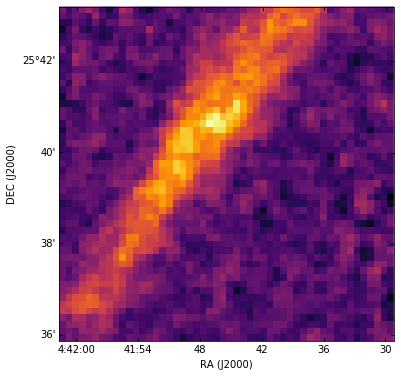

In [5]:
fig = plt.figure(figsize=(6, 7), constrained_layout=False)
ax1 = fig.add_subplot(111, projection=ls_tmc1.wcs)
ax1.imshow(np.sum(data, 0), cmap='inferno')
ra = ax1.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
dec = ax1.coords[1]
ax1.set_xlabel('RA (J2000)')
ax1.set_ylabel('DEC (J2000)')

In [4]:
c1ra1, c1ra2, c1dec1, c1dec2 = 30, 90, 130, 200
c2ra1, c2ra2, c2dec1, c2dec2 = 70, 115, 190, 235


cube3 = cube.with_spectral_unit(u.m/u.s, velocity_convention='radio', rest_value=head['RESTFRQ'] * u.Hz)[170:250] 
rad_v = cube3.spectral_axis
ls_cube = cube3[:, c1dec1:c1dec2, c1ra1:c1ra2]
ls_data = ls_cube.unmasked_data[:, :, :]
ls_head = ls_cube.header

us_cube = cube3[:, c2dec1:c2dec2, c2ra1:c2ra2]
us_data = us_cube.unmasked_data[:, :, :]
us_head = us_cube.header

fs_cube = cube3[:, c1dec1:c2dec2, c1ra1:c2ra2]
fs_data = fs_cube.unmasked_data[:, :, :]
fs_head = fs_cube.header

In [5]:
r_mod.fill_nan(us_data)
r_mod.fill_nan(ls_data)
r_mod.fill_nan(fs_data)

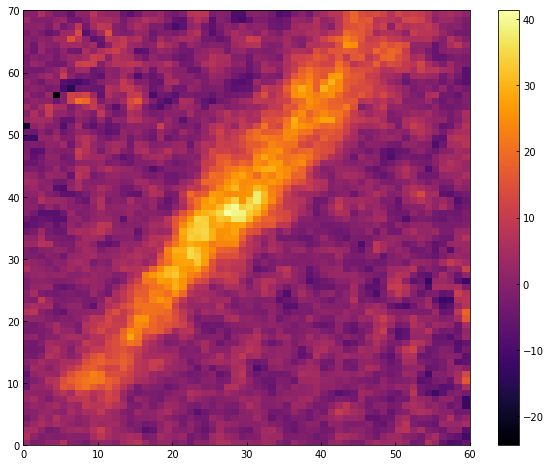

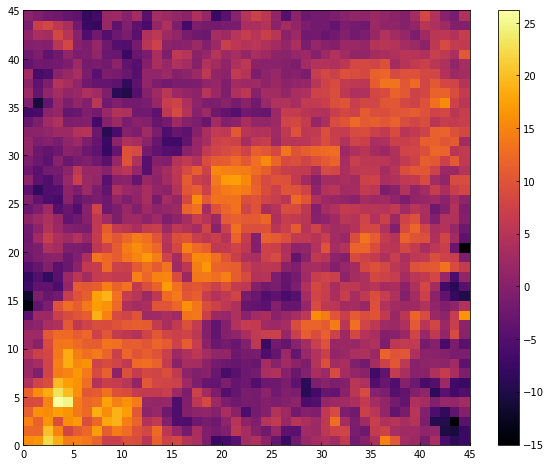

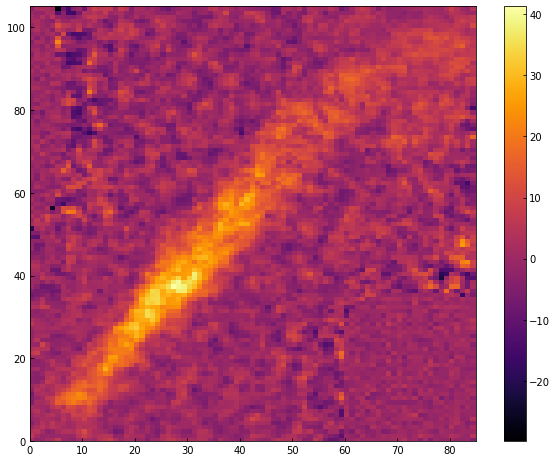

In [6]:
plt.figure(figsize=(10,8))
plt.pcolormesh(np.sum(ls_data, 0), cmap='inferno')
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.pcolormesh(np.sum(us_data, 0), cmap='inferno')
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.pcolormesh(np.sum(fs_data, 0), cmap='inferno')
plt.colorbar()
plt.show()

## ROHSA Initializer

In [98]:
filename = "HC2_HC5N_CubeEx.dat" #@param
fileout = "HC2_HC5N_CubeEx_gauss_run_0.dat" #@param
filename_noise = ''
n_gauss = 5         #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 100 #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 100       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_amp = 0.                                                                                                                                                                                                                                                           
lambda_var_mu = 0.                                                                                                                                                                                                                                                        
lambda_var_sig = 0.   #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 400         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
noise = ".false."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 

core = ROHSA(fs_data, hdr = fs_head)            
core.cube2dat(filename=filename)
core.gen_parameters(filename=filename, 
                    fileout=fileout,  
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    maxiter=maxiter,
                    descent=descent,
                    lstd=lstd,
                    ustd=ustd,
                    iprint=iprint,
                    save_grid=save_grid)


Generate HC2_HC5N_CubeEx.dat file readable by fortran
Generate parameters.txt file


In [99]:
! nohup ./ROHSA/src/ROHSA parameters.txt

appending output to nohup.out


In [100]:
gaussian = core.read_gaussian("HC2_HC5N_CubeEx_gauss_run_0.dat")
params = core.physical_gaussian(gaussian)
print("dim cube = " + str(gaussian.shape))

model = core.return_result_cube(gaussian=gaussian)

reconstructed_cube = core.return_result_cube(gaussian)

amplitude = params[0::3]
position = params[1::3]
dispersion = -1*params[2::3]

integral = amplitude * dispersion



Opening data file
dim cube = (15, 105, 85)


## First Section, Main Feature (Start)

In [39]:
#Levels to it, you and I know

#Based on SnR
l1std = np.arange(0, 6*np.std(integral[0]), np.std(integral[0]))
l2std = np.arange(0, 6*np.std(integral[1]), np.std(integral[1]))
l3std = np.arange(0, 6*np.std(integral[2]), np.std(integral[2]))

#Custom
l2 = [0.08, 0.12, 0.16, 0.20, 0.24, 0.28] 
l3 = np.arange(0.06, 0.14, 0.02)
ld3 = np.arange(0.1, 0.24, 0.02)


In [40]:
#Masks

mask1 = integral[0] > 0.1 #Good entire features of g1 and g3
g1 = np.empty(mask1.shape)
g1.fill(np.nan)
g1[mask1 == True] = 1

mask2 = integral[1] > 0.1 #Gets only the strongest parts of g2
g2 = np.empty(mask2.shape)
g2.fill(np.nan)
g2[mask2 == True] = 1

In [35]:
mask0 = integral[0] > 1
mask1 = integral[1] > 1
mask5 = integral[2] > 1
mask3 = mask0+mask1+mask5

mask2 = np.zeros(mask3.shape)

for j in range(mask3.shape[1]):
    for i in range(mask3.shape[0]):
        mask2[j][i] = int(mask3[j][i])
        if mask2[j][i] == 0:
            mask2[j][i] = np.nan
            
mask = mask2

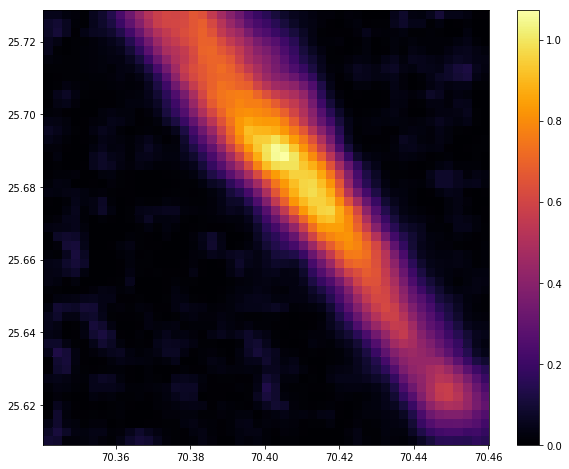

In [10]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], integral[0]+integral[1]+integral[2], cmap="inferno")
plt.colorbar()
plt.show()

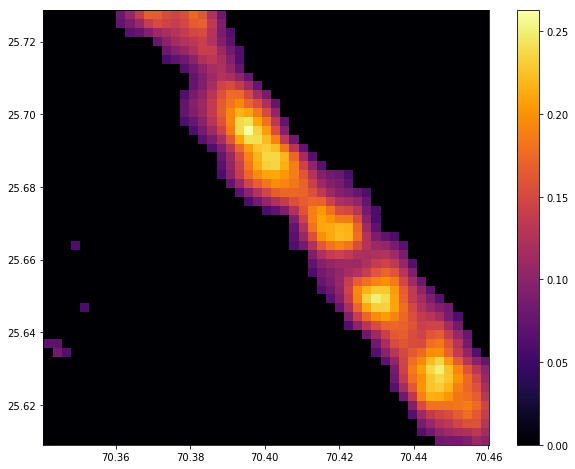

In [47]:
mask3 = integral[1] > np.std(integral[1])


plt.figure(figsize=(10,8))
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], mask3*integral[1], cmap="inferno")
plt.colorbar()
plt.show()

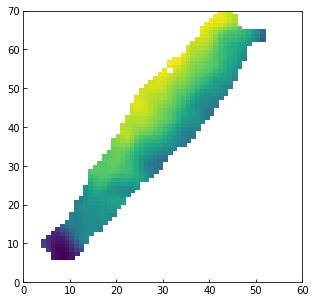

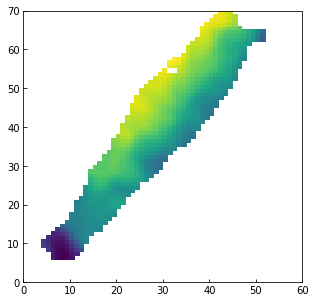

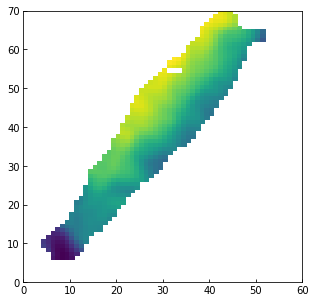

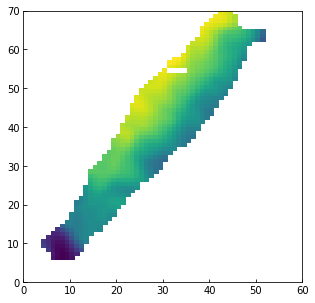

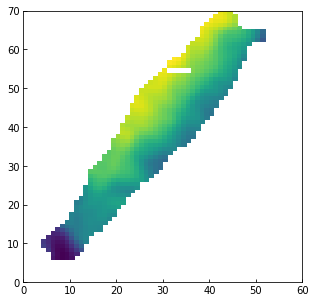

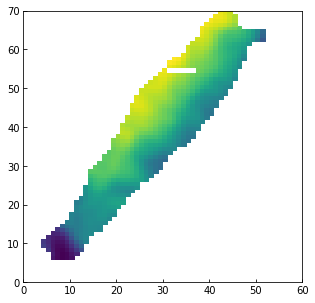

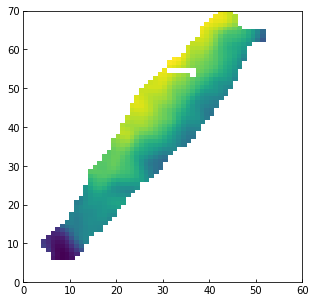

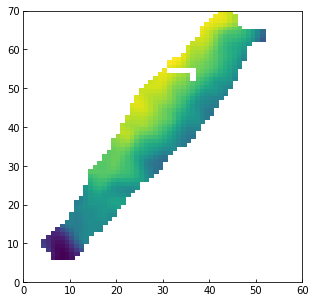

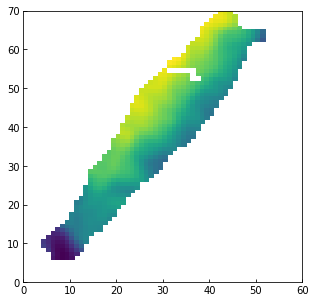

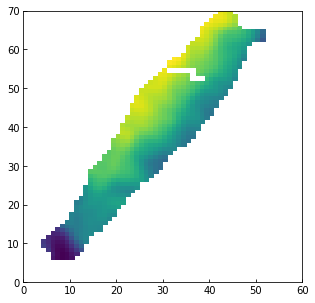

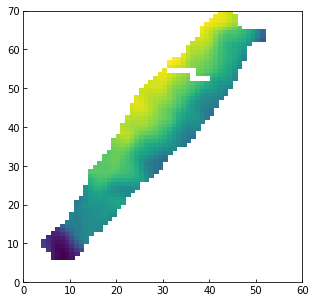

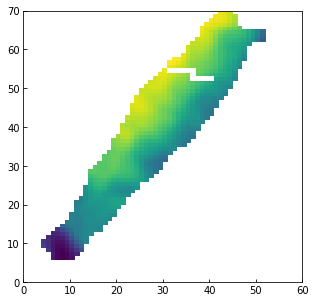

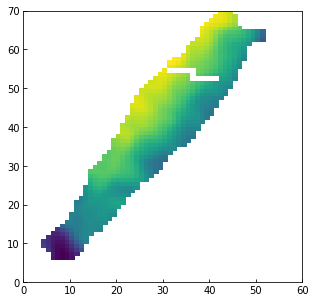

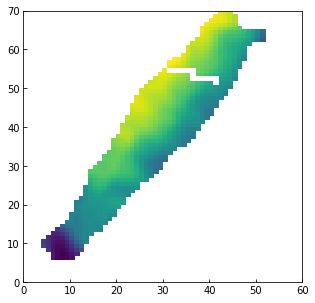

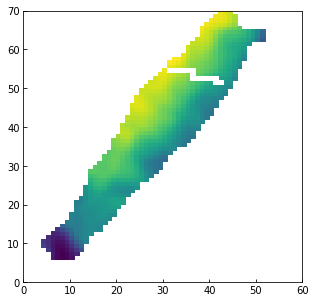

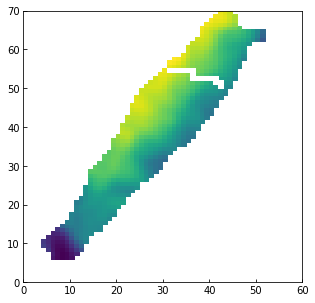

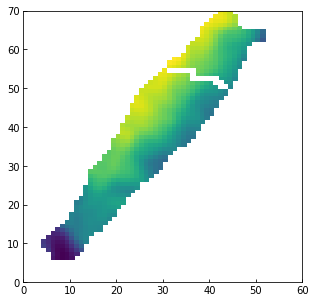

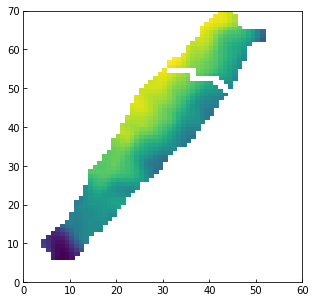

local min found


In [488]:
heights = r_mod.grad_dec(ls_g2*position[1], [31,54])

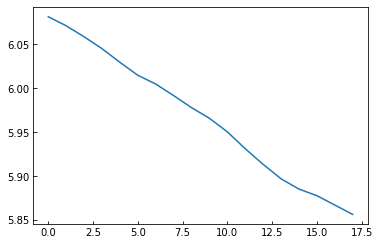

In [489]:
plt.plot(heights)

In [96]:
m = Fraction(-0.8).limit_denominator()
y, x = m.numerator, m.denominator

is_y_bigger = np.abs(y)>np.abs(x)

is_y_bigger, y, x, np.round(y/x)

(False, -4, 5, -1.0)

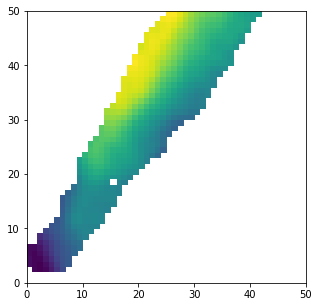

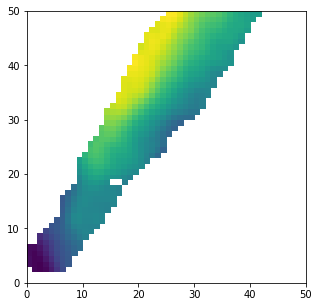

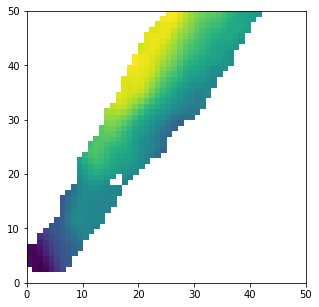

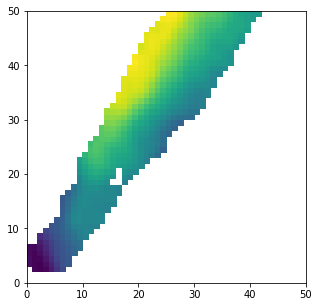

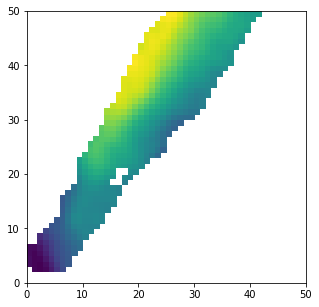

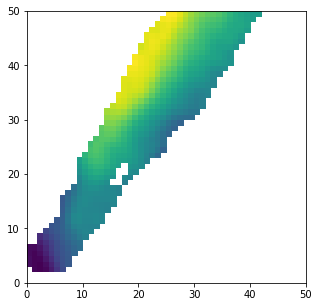

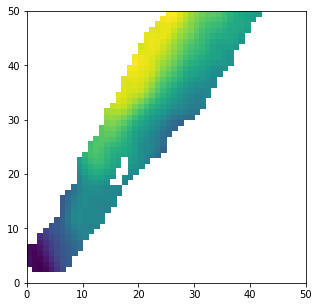

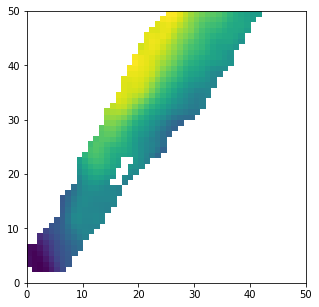

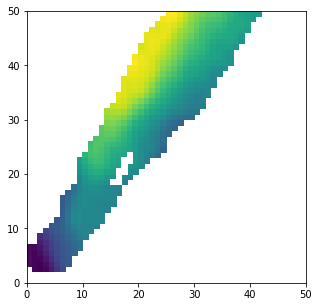

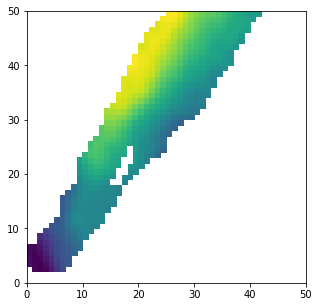

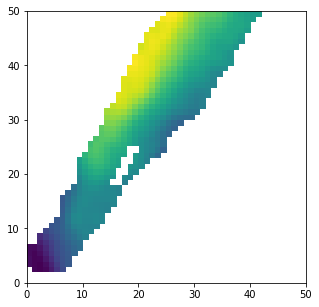

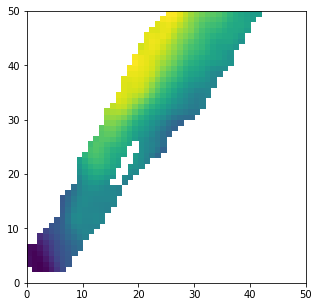

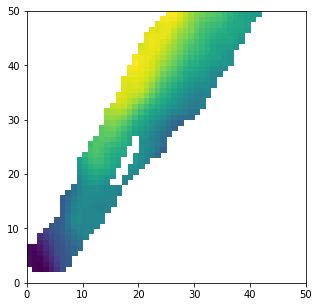

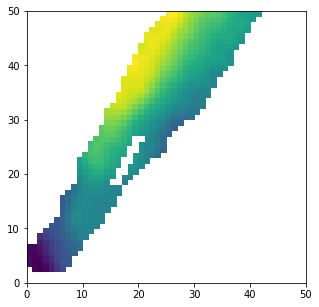

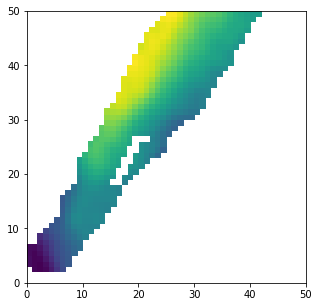

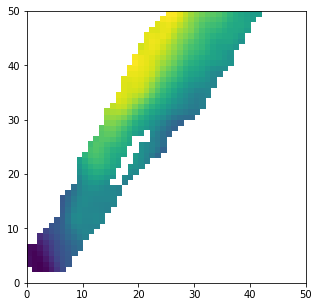

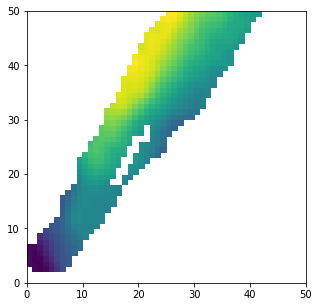

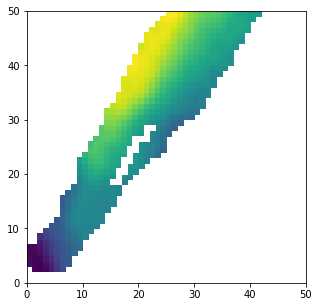

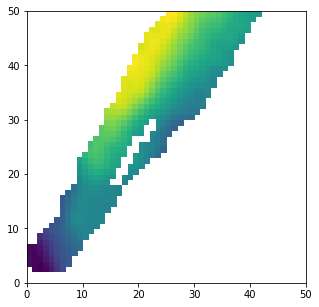

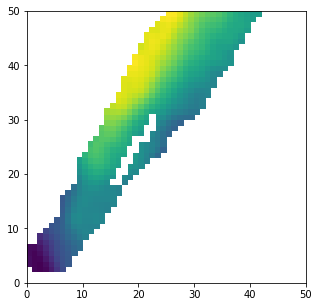

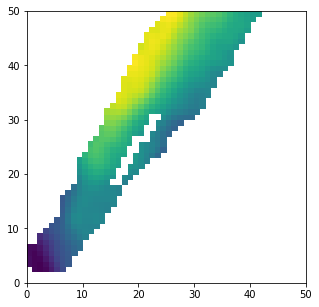

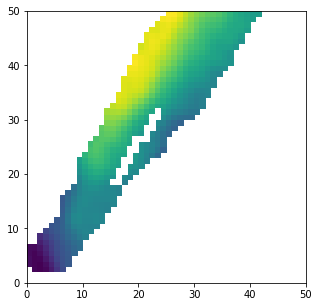

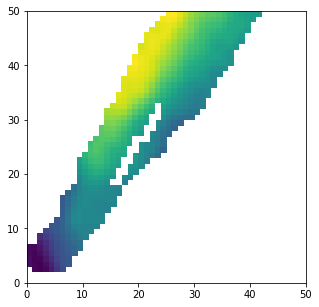

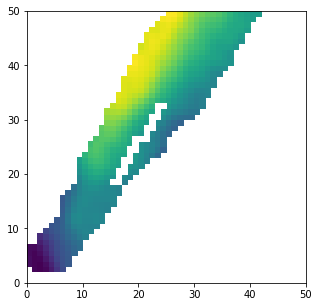

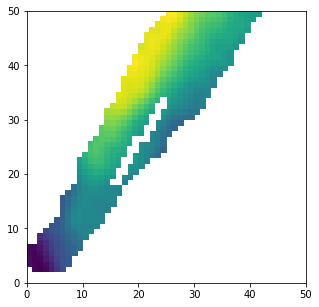

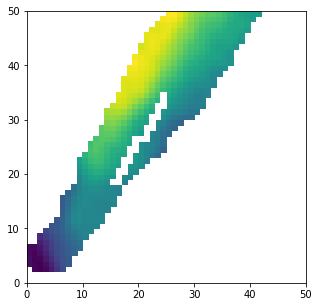

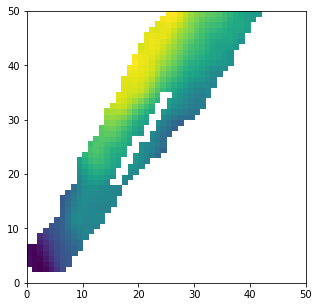

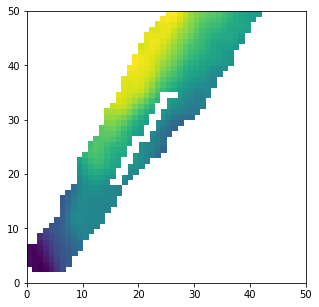

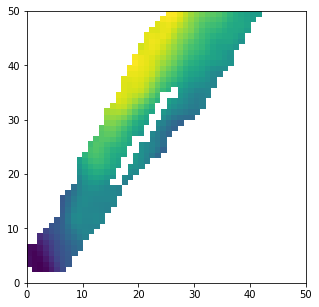

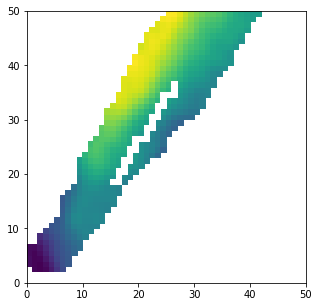

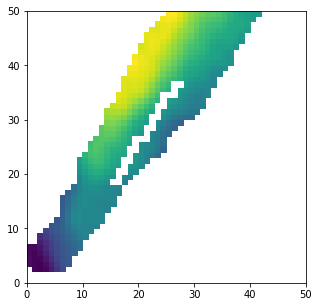

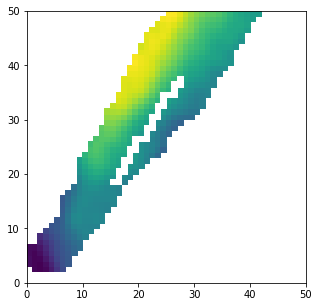

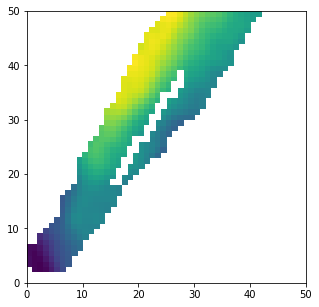

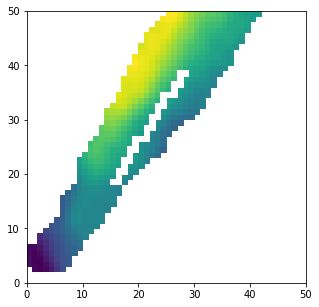

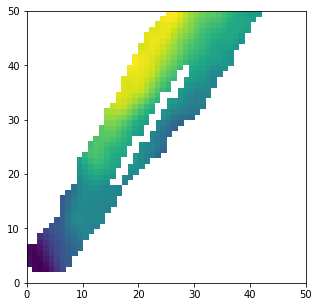

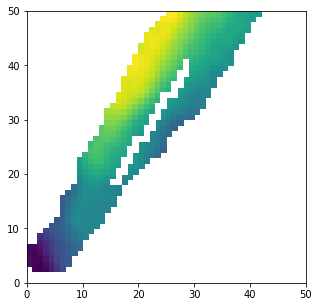

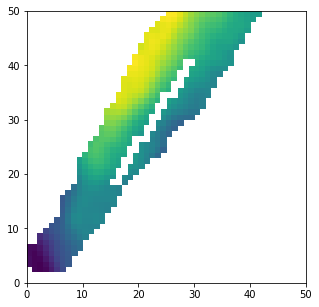

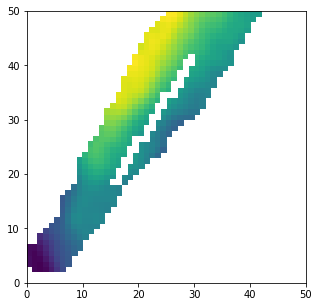

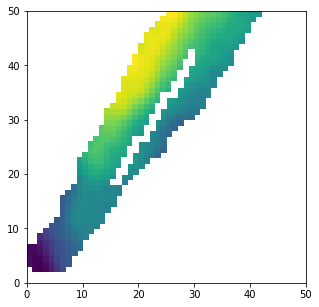

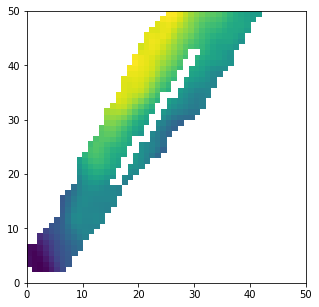

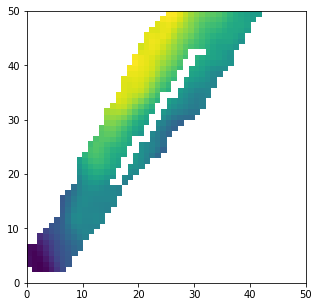

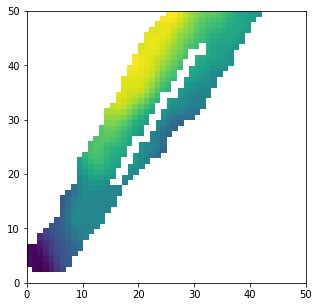

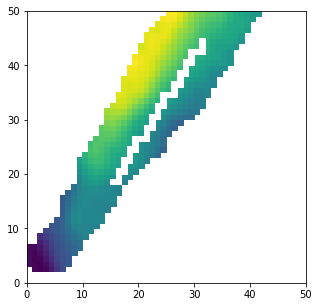

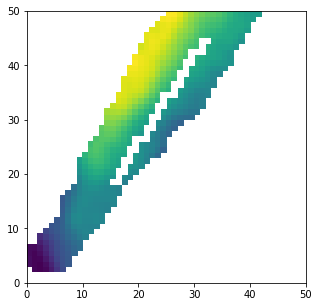

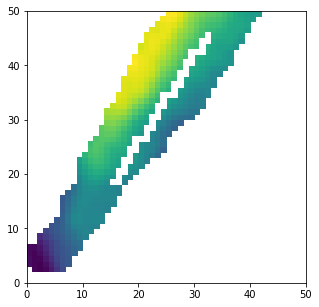

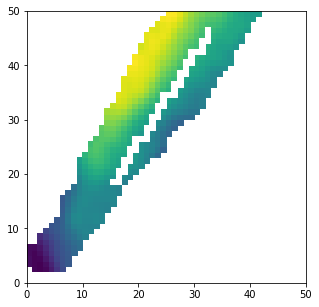

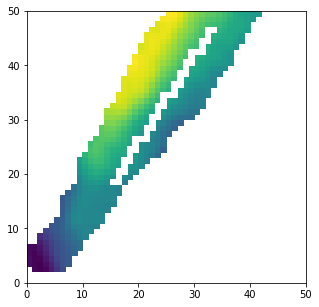

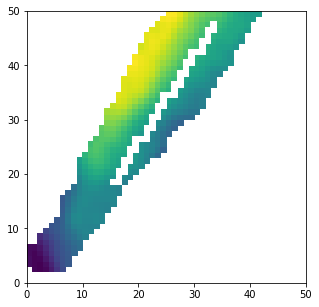

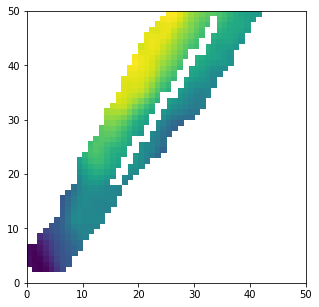

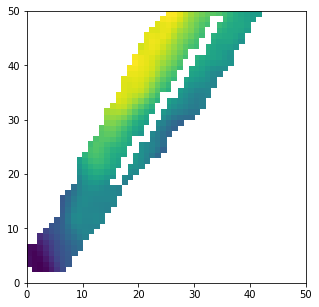

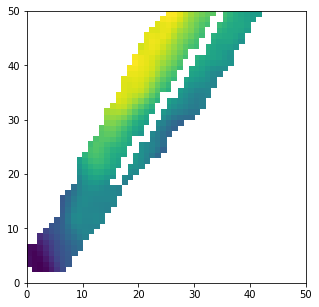

In [62]:
curve = r_mod.line_dec([15, 18], g*position[0], 8/5)

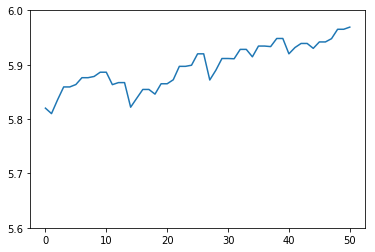

In [65]:

plt.plot(curve)

plt.yticks(l)
plt.show()

In [352]:
check_where([25, 25], g*position[0], 'up')

True

In [324]:
y = 8
x = 5
ratio = np.round(y/x)
ratio

2.0

In [74]:


1>1

position[0].shape[0]

50

In [57]:
for i in range(-3, 0):
    print(i)

-3
-2
-1


In [64]:
l = np.arange(5.6, 6.1, 0.1)

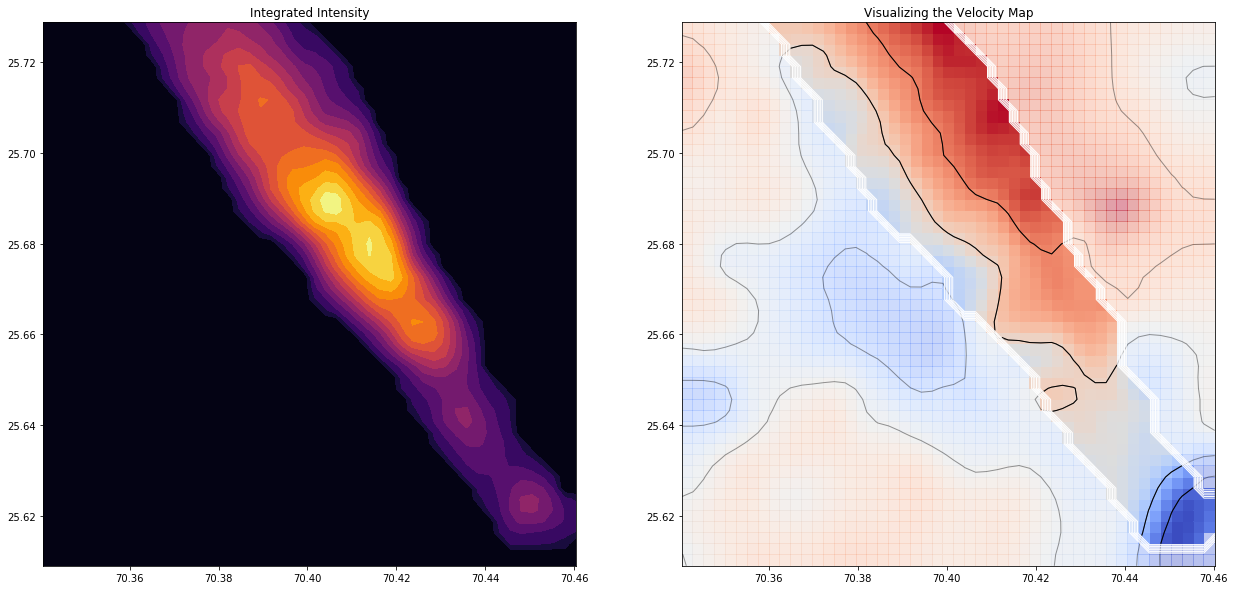

In [290]:
l = np.arange(5.6, 6.1, 0.1)
fig = plt.figure(figsize=[21, 10], constrained_layout=False)

gs = gridspec.GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.contourf(RA[ra1:ra2], DEC[dec1:dec2], mask1*integral[0], cmap="inferno", levels=np.arange(0, 0.86, 0.06))
ax1.set_title('Integrated Intensity')

ax2 = fig.add_subplot(gs[0, 1])
ax2.contour(RA[ra1:ra2], DEC[dec1:dec2], position[0], colors="k", linewidths=1, alpha=0.4, levels=l)
ax2.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], position[0], cmap="coolwarm", alpha=0.4)
ax2.contour(RA[ra1:ra2], DEC[dec1:dec2], g1*position[0], colors="k", linewidths=1, levels=l)
ax2.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g1*position[0], cmap="coolwarm")
ax2.contour(RA[ra1:ra2], DEC[dec1:dec2], mask1, colors="white", linewidths=1)
ax2.set_title('Visualizing the Velocity Map')

plt.savefig('g1_sides.png')

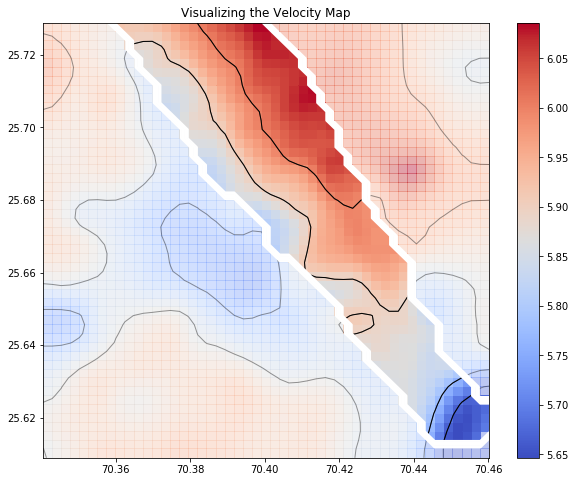

In [80]:
l = np.arange(5.6, 6.1, 0.1)
plt.figure(figsize=(10, 8))
plt.contour(RA[ra1:ra2], DEC[dec1:dec2], position[0], colors="k", linewidths=1, alpha=0.4, levels=l)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], position[0], cmap="coolwarm", alpha=0.4)
plt.contour(RA[ra1:ra2], DEC[dec1:dec2], g1*position[0], colors="k", linewidths=1, levels=l)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g1*position[0], cmap="coolwarm")
plt.colorbar()

plt.contour(RA[ra1:ra2], DEC[dec1:dec2], mask1, colors="white", linewidths=2)

#plt.contour(RA[ra1:ra2], DEC[dec1:dec2], mask1*integral[0], colors="white", levels=l1std)
plt.title('Visualizing the Velocity Map')
plt.show()

In [124]:
def vis(g, mask, outline, levels, alpha=0.3):
    """
    Visualize the Velocity map of a component
    """
    
    plt.figure(figsize=(10, 8))
    plt.contour(RA[ra1:ra2], DEC[dec1:dec2], position[g-1], colors="k", linewidths=1, alpha=alpha, levels=levels)
    plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], position[g-1], cmap="coolwarm", alpha=alpha)
    plt.contour(RA[ra1:ra2], DEC[dec1:dec2], mask*position[g-1], colors="k", linewidths=1, levels=levels)
    plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], mask*position[g-1], cmap="coolwarm")
    plt.colorbar()

    plt.contour(RA[ra1:ra2], DEC[dec1:dec2], outline, colors="white", linewidths=2)
    plt.title('Visualizing the velocity map of g'+str(g))
    plt.show()

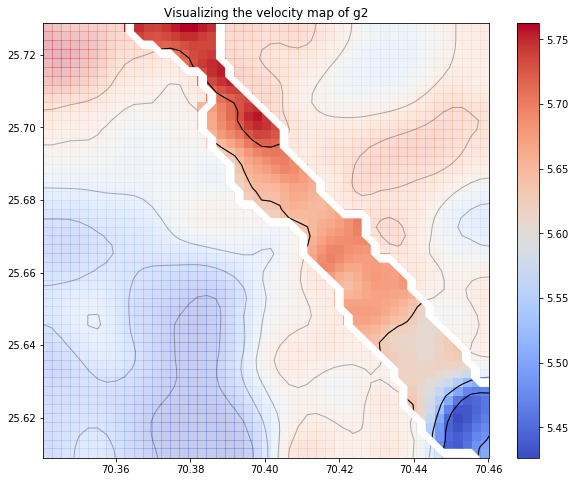

In [126]:

vis(2, g2, mask2, np.arange(5.4, 5.8, 0.08))

NameError: name 'nh3_data' is not defined

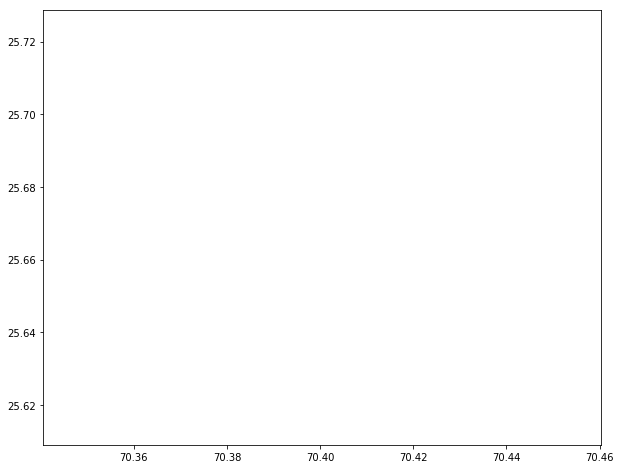

In [14]:
plt.figure(figsize=(10, 8))
plt.contour(RA[ra1:ra2], DEC[dec1:dec2], mask1*integral[0], colors='white', levels=l1std)
plt.contourf(RA[ra1:ra2], DEC[dec1:dec2], mask1*nh3_data[dec1:dec2, ra1:ra2], cmap="viridis")

plt.colorbar()
plt.show()

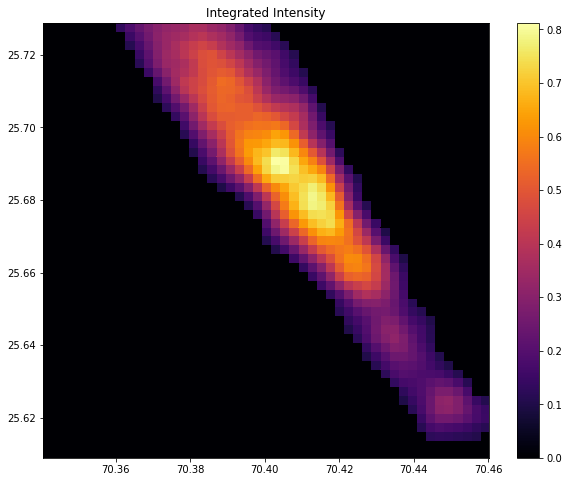

In [15]:
plt.figure(figsize=(10,8))
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], mask1*integral[0], cmap="inferno")
plt.colorbar()
#plt.contour(RA[ra1:ra2], DEC[dec1:dec2], mask*position[0], cmap="Greys")
#plt.contour(RA[ra1:ra2], DEC[dec1:dec2], mask1*dispersion[0], colors='white', levels=ld3)
plt.title('Integrated Intensity')

plt.show()

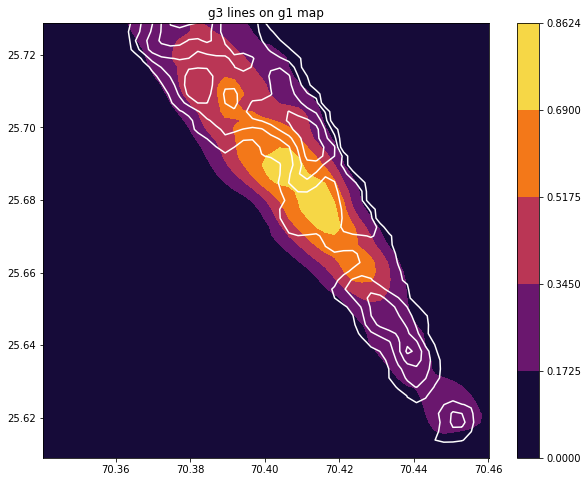

In [16]:
plt.figure(figsize=(10,8))
plt.contourf(RA[ra1:ra2], DEC[dec1:dec2], mask1*integral[0], cmap="inferno", levels=l1std)
plt.colorbar()
plt.contour(RA[ra1:ra2], DEC[dec1:dec2], mask1*integral[2], colors='white', levels=l3std)
plt.title('g3 lines on g1 map')
plt.show()

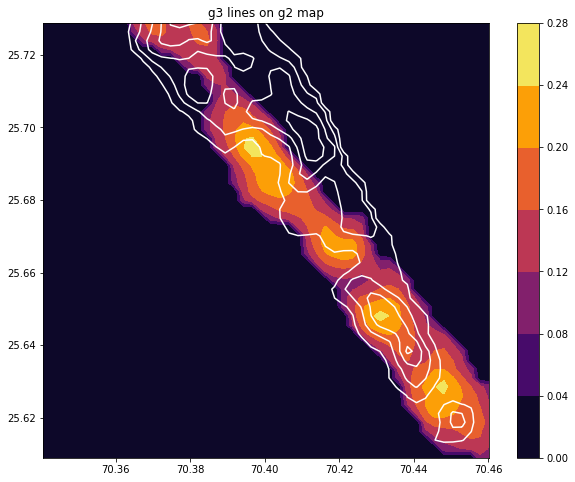

In [17]:


plt.figure(figsize=(10,8))
plt.contourf(RA[ra1:ra2], DEC[dec1:dec2], mask2*integral[1], cmap="inferno")
plt.colorbar()
plt.contour(RA[ra1:ra2], DEC[dec1:dec2], mask1*integral[2], colors="white", levels=l3std)
plt.title('g3 lines on g2 map')
plt.show()

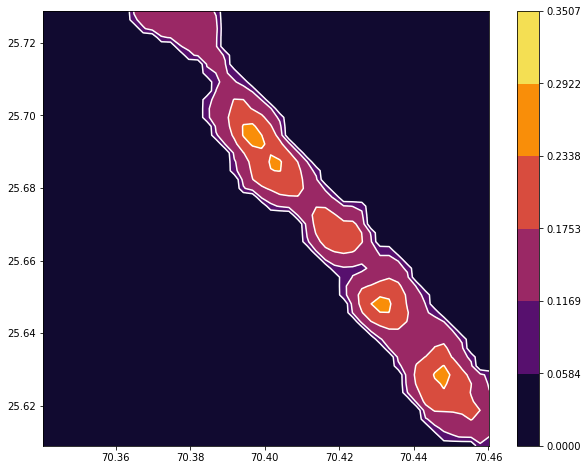

In [18]:
plt.figure(figsize=(10,8))

plt.contourf(RA[ra1:ra2], DEC[dec1:dec2], mask2*integral[1], cmap="inferno", levels=l2std)
plt.colorbar()

plt.contour(RA[ra1:ra2], DEC[dec1:dec2], mask2*integral[1], colors="white", levels=l2std)
plt.show()


In [19]:
def dist(x1, y1, x2, y2):
    """
    find distance between two points in the cartesian plane
    """

    d = np.sqrt(  (x2-x1)**2 + (y2-y1)**2 )
    return d
    
    
peaks = find_peaks(integral[1], 0.2)
peak_pts = np.zeros([50, 50])

for i in peaks:
    peak_pts[i[1]][i[0]] = 0.1

dists = []
for i in range(0, len(peaks)-1):
    x1, y1 = peaks[i][0], peaks[i][1]
    x2, y2 = peaks[i+1][0], peaks[i+1][1]
    dists.append(pix_scale_au*dist(x1, y1, x2, y2)/u.au)
dists = np.asarray(dists) 

In [20]:
dists

array([13094.21870113,  9931.09295402, 14832.84196687,  4441.31978721])

In [21]:
x1, y1 = peaks[0][0], peaks[0][1]
x2, y2 = peaks[1][0], peaks[1][1]

dist(x1, y1, x2, y2)

10.63014581273465

# Intensity

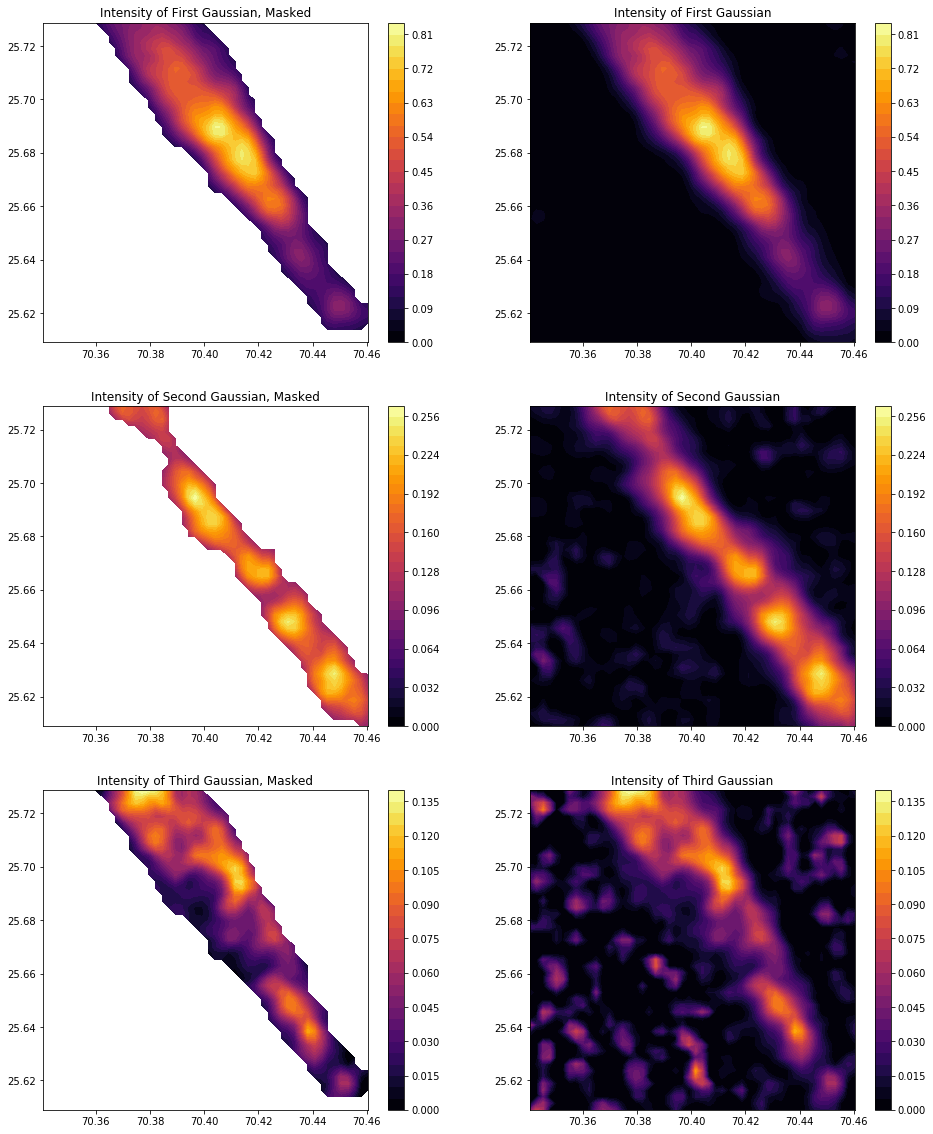

In [22]:
plt.figure(figsize=(16, 20))

plt.subplot(3,2,1)
plt.contourf(RA[ra1:ra2], DEC[dec1:dec2], g1*integral[0], cmap="inferno", levels=np.arange(0, 0.86, 0.03))
plt.colorbar()
plt.title('Intensity of First Gaussian, Masked')
plt.subplot(3,2,2)
plt.contourf(RA[ra1:ra2], DEC[dec1:dec2], integral[0], cmap="inferno", levels=np.arange(0, 0.86, 0.03))
plt.colorbar()
plt.title('Intensity of First Gaussian')

plt.subplot(3,2,3)
plt.contourf(RA[ra1:ra2], DEC[dec1:dec2], g2*integral[1], cmap="inferno", levels=np.arange(0, 0.27, 0.008))
plt.colorbar()
plt.title('Intensity of Second Gaussian, Masked')
plt.subplot(3,2,4)
plt.contourf(RA[ra1:ra2], DEC[dec1:dec2], integral[1], cmap="inferno", levels=np.arange(0, 0.27, 0.008))
plt.colorbar()
plt.title('Intensity of Second Gaussian')

plt.subplot(3,2,5)
plt.contourf(RA[ra1:ra2], DEC[dec1:dec2], g1*integral[2], cmap="inferno", levels=np.arange(0, 0.14, 0.005))
plt.colorbar()
plt.title('Intensity of Third Gaussian, Masked')
plt.subplot(3,2,6)
plt.contourf(RA[ra1:ra2], DEC[dec1:dec2], integral[2], cmap="inferno", levels=np.arange(0, 0.14, 0.005))
plt.colorbar()
plt.title('Intensity of Third Gaussian')

#plt.savefig('g3_int.png')
plt.show()


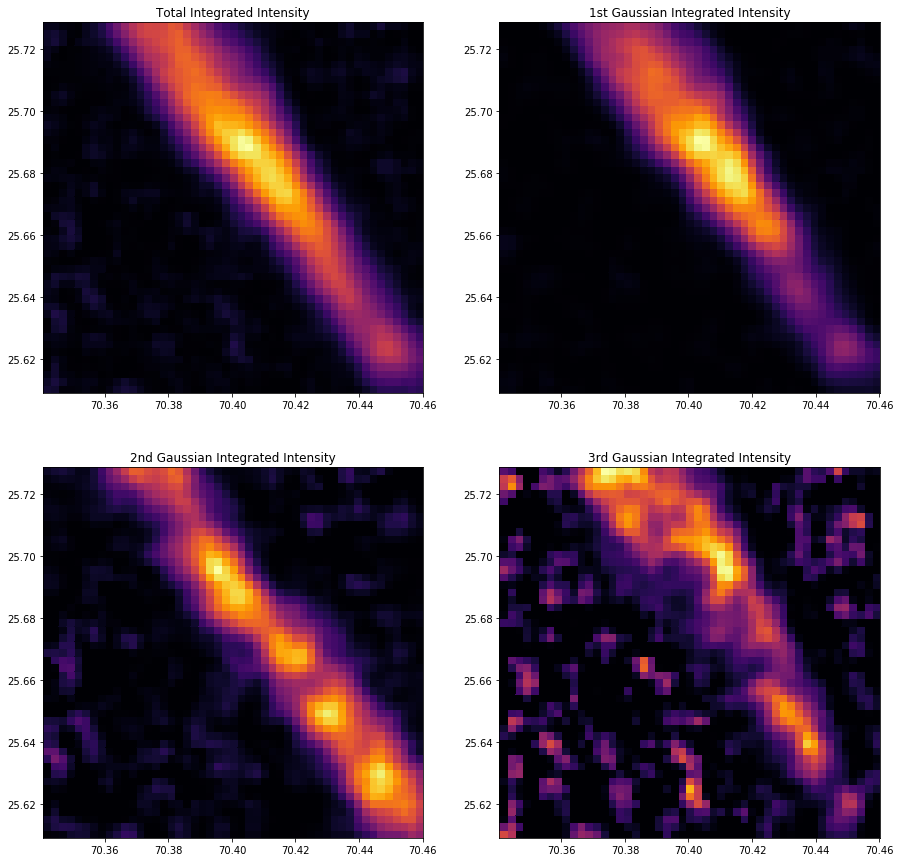

In [23]:
fig = plt.figure(figsize=[15, 15], constrained_layout=False)

gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], integral[0]+integral[1]+integral[2], cmap="inferno")
ax1.set_title('Total Integrated Intensity')

ax2 = fig.add_subplot(gs[0, 1])
ax2.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], integral[0], cmap="inferno")
ax2.set_title('1st Gaussian Integrated Intensity')

ax3 = fig.add_subplot(gs[1, 0])
ax3.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], integral[1], cmap="inferno")
ax3.set_title('2nd Gaussian Integrated Intensity')

ax4 = fig.add_subplot(gs[1, 1])
ax4.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], integral[2], cmap="inferno")
ax4.set_title('3rd Gaussian Integrated Intensity')

plt.show()

# Mean Velocity

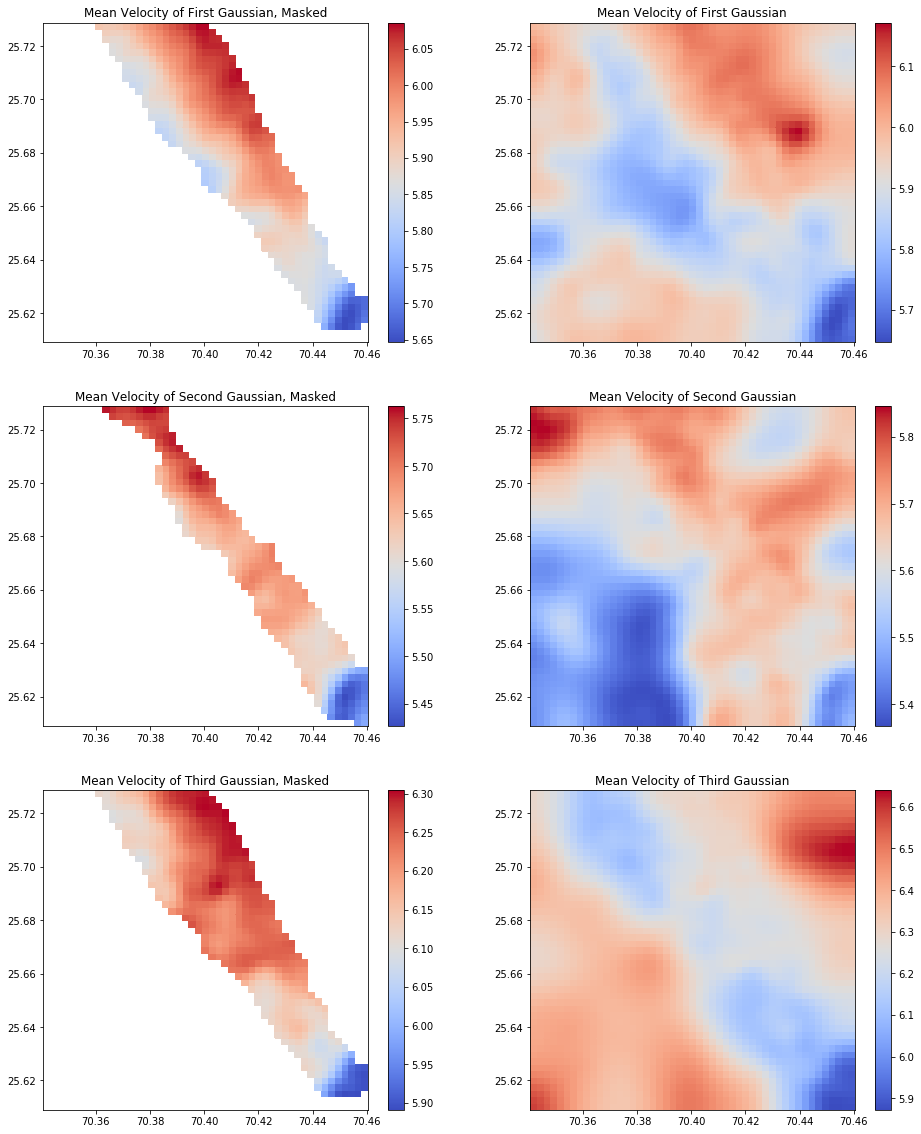

In [24]:
plt.figure(figsize=(16, 20))

plt.subplot(3,2,1)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g1*position[0], cmap="coolwarm")
plt.colorbar()
plt.title('Mean Velocity of First Gaussian, Masked')
plt.subplot(3,2,2)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], position[0], cmap="coolwarm")
plt.colorbar()
plt.title('Mean Velocity of First Gaussian')

plt.subplot(3,2,3)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g2*position[1], cmap="coolwarm")
plt.colorbar()
plt.title('Mean Velocity of Second Gaussian, Masked')
plt.subplot(3,2,4)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], position[1], cmap="coolwarm")
plt.colorbar()
plt.title('Mean Velocity of Second Gaussian')

plt.subplot(3,2,5)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g1*position[2], cmap="coolwarm")
plt.colorbar()
plt.title('Mean Velocity of Third Gaussian, Masked')
plt.subplot(3,2,6)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], position[2], cmap="coolwarm")
plt.colorbar()
plt.title('Mean Velocity of Third Gaussian')

#plt.savefig('g3_vel.png')
plt.show()

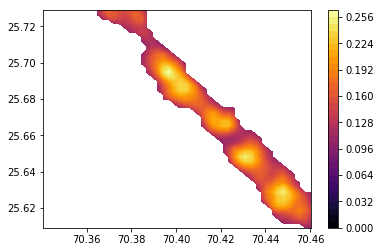

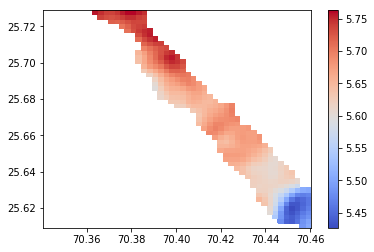

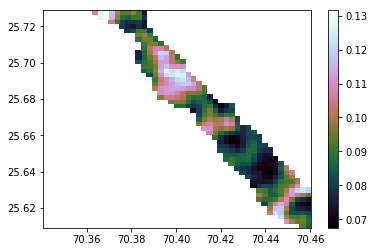

In [77]:
plt.contourf(RA[ra1:ra2], DEC[dec1:dec2], g2*integral[1], cmap="inferno", levels=np.arange(0, 0.27, 0.008))
plt.colorbar()
plt.show()
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g2*position[1], cmap="coolwarm")
plt.colorbar()
plt.show()
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g2*dispersion[1], cmap="cubehelix")
plt.colorbar()
plt.show()

# Velocity Dispersion


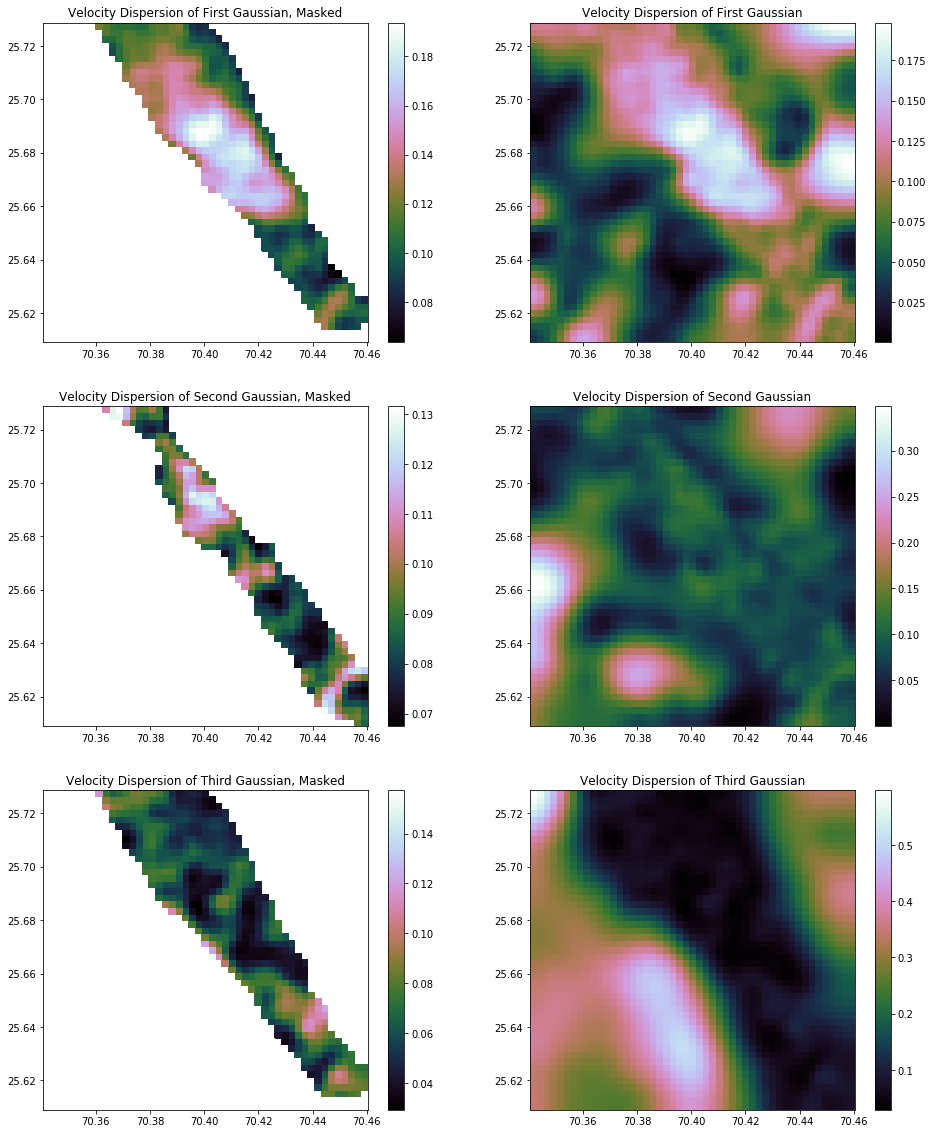

In [25]:
plt.figure(figsize=(16, 20))

plt.subplot(3,2,1)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g1*dispersion[0], cmap="cubehelix")
plt.colorbar()
plt.title('Velocity Dispersion of First Gaussian, Masked')
plt.subplot(3,2,2)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], dispersion[0], cmap="cubehelix")
plt.colorbar()
plt.title('Velocity Dispersion of First Gaussian')

plt.subplot(3,2,3)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g2*dispersion[1], cmap="cubehelix")
plt.colorbar()
plt.title('Velocity Dispersion of Second Gaussian, Masked')
plt.subplot(3,2,4)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], dispersion[1], cmap="cubehelix")
plt.colorbar()
plt.title('Velocity Dispersion of Second Gaussian')

plt.subplot(3,2,5)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g1*dispersion[2], cmap="cubehelix")
plt.colorbar()
plt.title('Velocity Dispersion of Third Gaussian, Masked')

plt.subplot(3,2,6)
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], dispersion[2], cmap="cubehelix")
plt.colorbar()
plt.title('Velocity Dispersion of Third Gaussian')

#plt.savefig('g3_disp.png')
plt.show()

# Check Residuals

In [41]:
g = g1

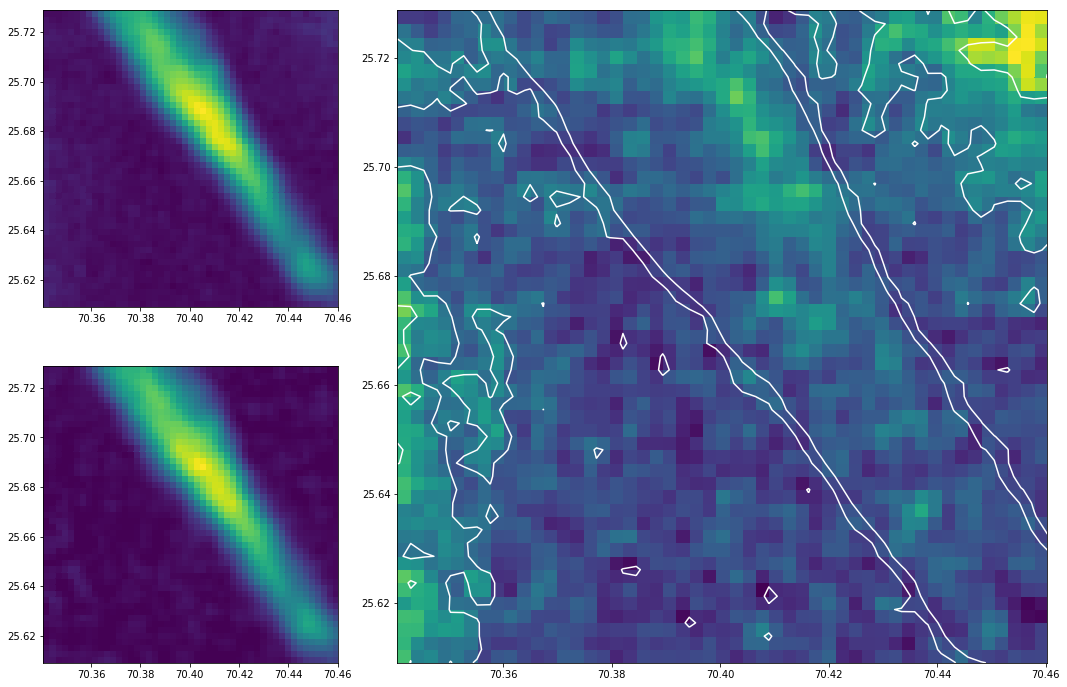

In [71]:
fig = plt.figure(figsize=[18, 12], constrained_layout=False)

gs = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0])

ax1 = fig.add_subplot(gs1[0])
ax1.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], np.std(data,0))
#ax1.contour(RA[ra1:ra2], DEC[dec1:dec2], np.std(data,0), colors='white', levels=np.arange(0, 0.25, 0.05))

ax2 = fig.add_subplot(gs1[1])
ax2.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], np.std(reconstructed_cube, 0))
#ax2.contour(RA[ra1:ra2], DEC[dec1:dec2], np.std(data,0), colors='white', levels=np.arange(0, 0.25, 0.05))

gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1:])

ax3 = fig.add_subplot(gs2[0])
ax3.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], np.std(data - reconstructed_cube, 0))
ax3.contour(RA[ra1:ra2], DEC[dec1:dec2], np.std(data,0), colors='white', levels=np.arange(0.0, 0.25, 0.05))

plt.show()

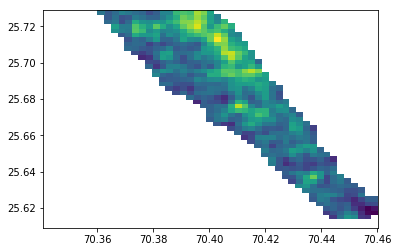

In [72]:
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g*np.std(data - reconstructed_cube, 0))

In [33]:
chi2s.shape

(50, 50)

In [73]:
chi2s = np.zeros(np.sum(data, 0).shape)
for i in range(0, chi2s.shape[1]):
    for j in range(0, chi2s.shape[0]):

        spec = data.T[i][j]
        fit = reconstructed_cube.T[i][j]
        res = spec - fit
        std = np.std(res)
        deg = len(rad_v) - 3
        chi2 = np.sum((res)**2)/std**2/deg
        chi2s[i][j] = chi2

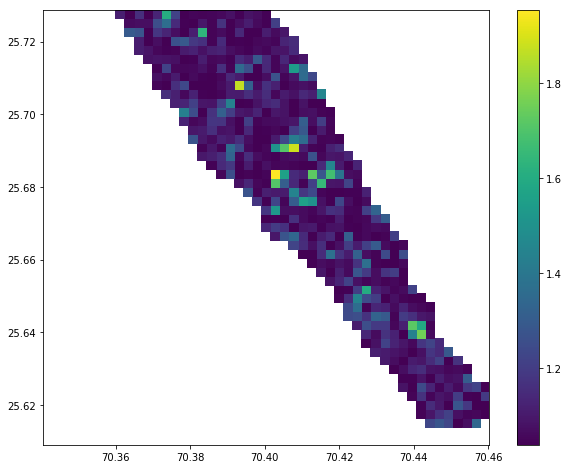

In [76]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(RA[ra1:ra2], DEC[dec1:dec2], g*chi2s)
plt.colorbar()
plt.show()

In [168]:
chi2_3g = np.sum(chi2s)/len(chi2s)

In [169]:
chi2_1g, chi2_2g, chi2_3g, #chi2_4g, chi2_5g

(1.1005639016032667, 1.1189381874405666, 1.136694306365878)

In [159]:
chi2s

[1.0662549799734056,
 1.4923767138180095,
 1.2637931535698383,
 1.039214284560273,
 1.082861185350179,
 1.692651762105476,
 1.1301238325341239,
 1.3396193935848904,
 1.1850841529574752,
 1.0741120006636273,
 1.0405271551521378,
 1.2312941484934061,
 1.280732891571142,
 1.232301544756315,
 1.039025882989085,
 1.0979674038155305,
 1.049749356165472,
 1.075362264594808,
 1.2142231553856144,
 1.1662575197268779,
 1.0899206730918996,
 1.0465865747068774,
 1.0579752586771123,
 1.0436704386222289,
 1.1873793042914376,
 1.281473408100516,
 1.0392052459875087,
 1.0978672598946984,
 1.1504992975178951,
 1.042985819315658,
 1.056438138461987,
 1.0735206857360229,
 1.0393672454500436,
 1.045618345252091,
 1.201809613579805,
 1.0731017343359128,
 1.091173706193761,
 1.051893693084189,
 1.1676332753545013,
 1.0494483069842988,
 1.0870537149251356,
 1.0690493475916407,
 1.1442450440980085,
 1.1835806966720328,
 1.0617204003177785,
 1.110348931777028,
 1.0529259727997262,
 1.1315266960843267,
 1.24374

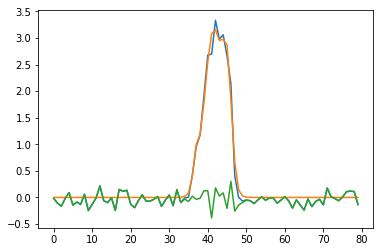

1.1539516004426644

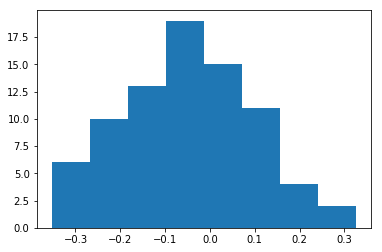

In [173]:
x, y = 20, 25

plt.plot(data.T[x][y])
plt.plot(reconstructed_cube.T[x][y])
plt.plot(data.T[x][y] - reconstructed_cube.T[x][y])
#plt.plot((data.T[x][y] - reconstructed_cube.T[x][y])**2)
plt.show()

plt.hist(spec-fit, bins='auto')
res = spec-fit
np.sum((res)**2)/np.std(res)**2/(len(res)-3)

In [137]:
spec = data.T[x][y]
fit = reconstructed_cube.T[x][y]
std = np.std(spec)

np.sum((spec-fit)**2)  /   ((std))

2.9905753879582555

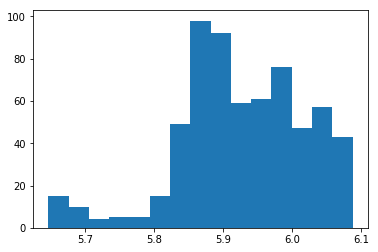

In [63]:
g1_vel = np.ravel(mask1*position[0])
plt.hist(g1_vel[g1_vel != 0], bins='auto')
plt.show()

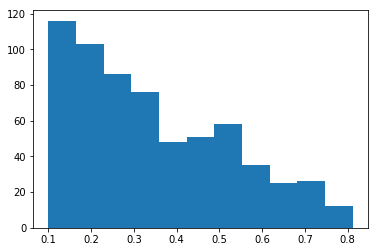

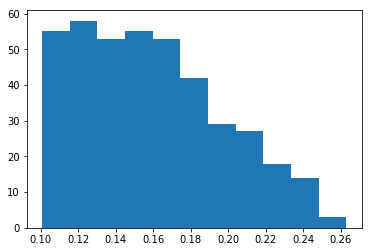

In [67]:
g1_disp = np.ravel(mask1*integral[0])
g1_disp = g1_disp[g1_disp != 0]
plt.hist(g1_disp, bins='auto')
plt.show()
g2_disp = np.ravel(mask2*integral[1])
g2_disp = g2_disp[g2_disp != 0]
plt.hist(g2_disp, bins='auto')
plt.show()

In [60]:
def plot_spect(self, gaussian, idy=0, idx=0, line=0):
        """
        Based on:
        line = 0
        line = 1
        line = 2
        line = 3
        
        Highlight:
        Total
        first
        second
        third
        """
        n_gauss = gaussian.shape[0]/3
        x = np.arange(self.cube.shape[0])

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)

        if self.hdr is not None :
            if not self.hdr["CRVAL3"] : print("Missing CRVAL3 keyword")
            v = self.mean2vel(self.hdr["CRVAL3"]*1.e-3, self.hdr["CDELT3"]*1.e-3, self.hdr["CRPIX3"], x)
            if v[0] > v[1] : v = v[::-1]
            ax.step(v, self.cube[:,idy,idx], color='cornflowerblue')
            tot = np.zeros(self.cube.shape[0])
            for i in np.arange(n_gauss):
                spectrum = self.gauss(x, gaussian[int(0+(3*i)),idy,idx], gaussian[int(1+(3*i)),idy,idx], gaussian[int(2+(3*i)),idy,idx])
                tot += spectrum
                if line==i:
                    ax.plot(v, spectrum, color="r")
                else:
                    ax.plot(v, spectrum, color='k')
                
            ax.plot(v, tot, color="k") 
            ax.set_ylabel(r'T [k]')
            ax.set_xlabel(r'v [km s$^{-1}$]')
            
            plt.xlim([5, 7.5])
            
            plt.savefig('third_line.png')
        else:
            ax.step(x, self.cube[:,idy,idx], color='cornflowerblue')
            tot = np.zeros(self.cube.shape[0])
            for i in np.arange(n_gauss):
                spectrum = self.gauss(x, gaussian[int(0+(3*i)),idy,idx], gaussian[int(1+(3*i)),idy,idx], gaussian[int(2+(3*i)),idy,idx])
                tot += spectrum
                ax.plot(x, spectrum, color="k")
            ax.plot(x, tot, color="r") 
            ax.set_ylabel(r'T [k]')
            ax.set_xlabel(r'idx [pixel unit]')
             
        return 0

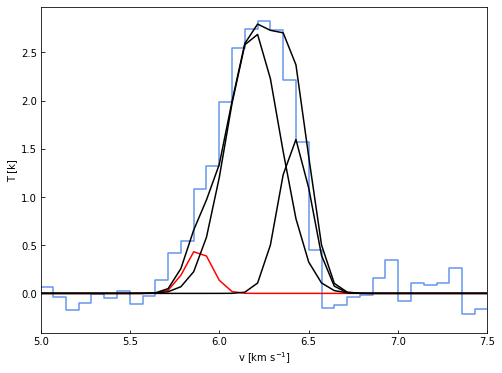

In [61]:
plot_spect(core, gaussian, idx=34, idy=40, line=0)
plt.show()

In [384]:
help(core.plot_spect)

Help on method plot_spect in module ROHSApy.core:

plot_spect(gaussian, idy=0, idx=0) method of ROHSApy.core.ROHSA instance



In [332]:
int(params.shape[0]/3), pvalues

(3, array([0.1, 1. ]))

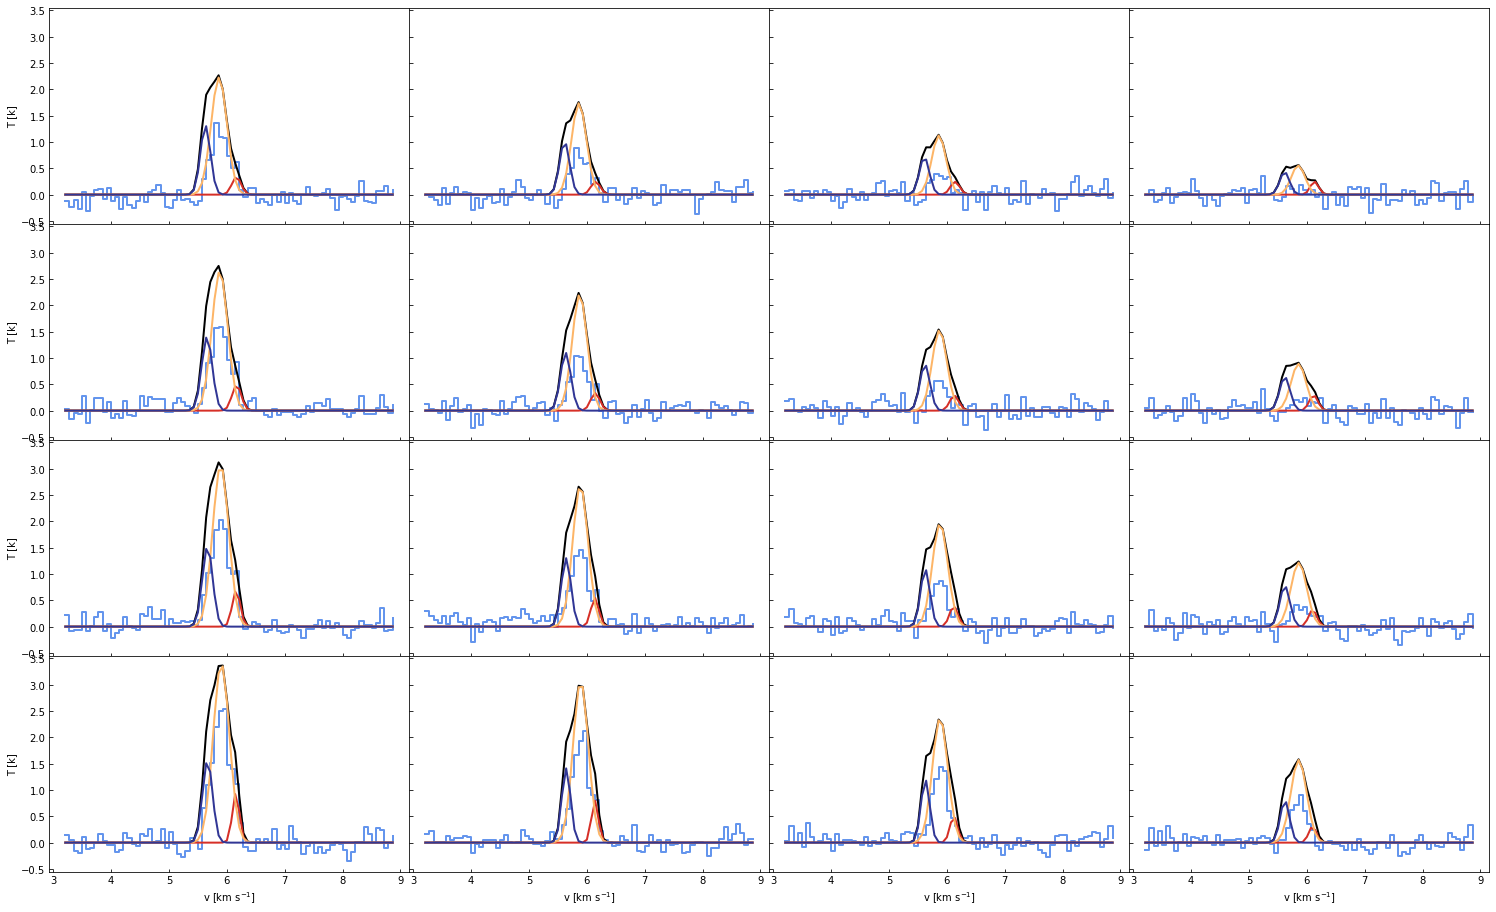

In [12]:
#Plot mosaic spectra
pvalues = np.logspace(-1, 0, 3)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
     return (pval - pmin) / float(pmax - pmin)

ny = 4; nx = 4
center_y = 40; center_x = 35
cb = "magenta"
cw = "crimson"
fig, axs = plt.subplots(ny, nx, sharex=True, sharey=True, figsize=(20,12))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)
for i in np.arange(ny):
    for j in np.arange(nx):
        axs[i][j].step(core.v, data[:,center_y+i,center_x+j], color='cornflowerblue', linewidth=2.)
        axs[i][j].plot(core.v, reconstructed_cube[:,center_y+i,center_x+j], linestyle="-", linewidth=2., color="k")
        for k in range(int(params.shape[0]/3)):
            axs[i][j].plot(core.v, core.gauss(np.arange(len(core.v)), 
                                            gaussian[0::3][k][center_y+i,center_x+j],
                                            gaussian[1::3][k][center_y+i,center_x+j],
                                            gaussian[2::3][k][center_y+i,center_x+j]),
                                            linewidth=2., color=plt.cm.RdYlBu(pvalues[k]))
        if j == 0: axs[i][j].set_ylabel(r'T [k]')
        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
plt.show()

## First Section, Main Feature (End)

# Next Steps

### Starting thinking about quantitative velocity gradient -- in the works
### Finalize proving we need three components -- 
### Workshop the abstract --
### Start opening up other parts of the data, consider replacing nan columns with noise columns or zero columns --
### Some relative intensity numbers, dispersions
### Calculate column density
### compare TMC-1 fs vs us+ls, combing G's by intensity?

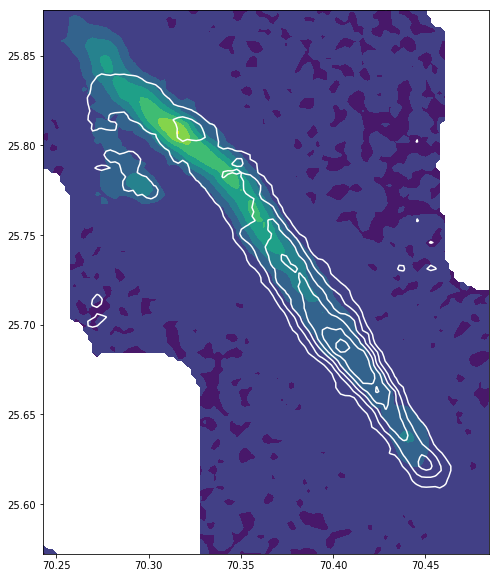

In [158]:
plt.figure(figsize=(8, 10))
plt.contourf(RA[25:125], DEC[120:245], nh3_data[120:245, 25:125])
plt.contour(RA[25:125], DEC[120:245], integral[0]+integral[1]+integral[2], colors="white", levels=np.linspace(0, 14, 7))
plt.show()

# TMC-1, full

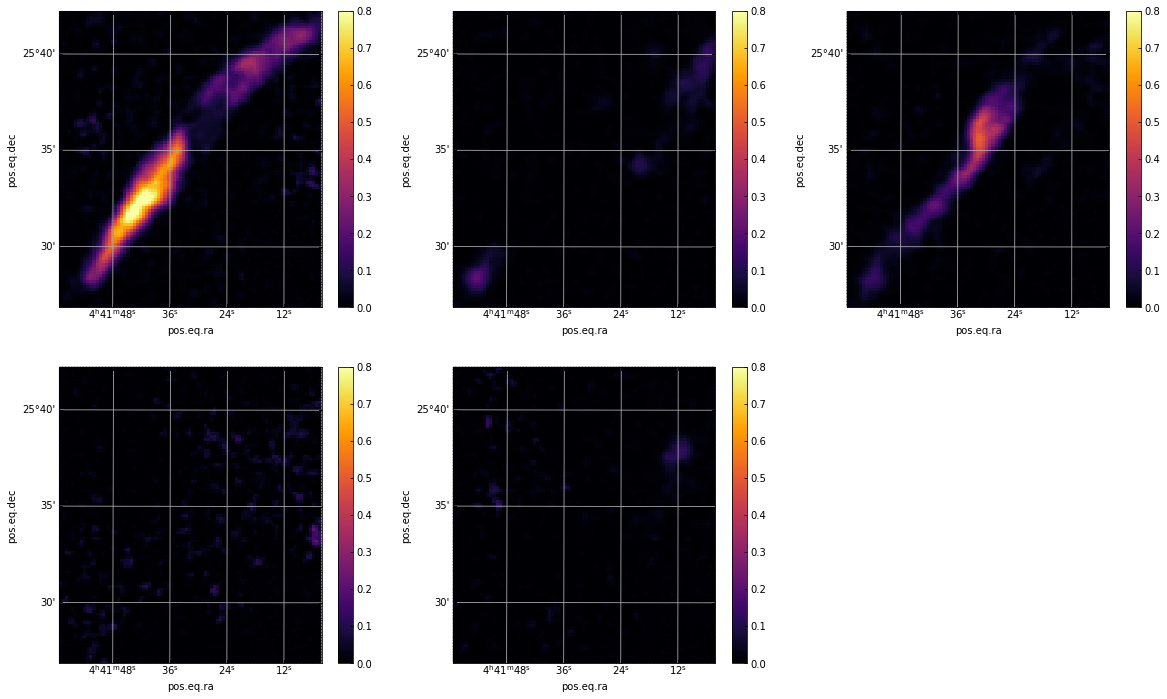

In [104]:
fig = plt.figure(figsize=[20, 12], constrained_layout=False)


ax1 = fig.add_subplot(231, projection=fs_tmc1.wcs)
im1 = ax1.pcolormesh(integral[0], cmap="inferno", vmax=0.8)
cbar1 = plt.colorbar(im1)


ax2 = fig.add_subplot(232, projection=fs_tmc1.wcs)
im2 = ax2.pcolormesh(integral[1], cmap="inferno", vmax=0.8)
#plt.yticks([])
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(233, projection=fs_tmc1.wcs)
im3 = ax3.pcolormesh(integral[2], cmap="inferno", vmax=0.8)
#plt.yticks([])
cbar3 = plt.colorbar(im3)

ax4 = fig.add_subplot(234, projection=fs_tmc1.wcs)
im4 = ax4.pcolormesh(integral[3], cmap="inferno", vmax=0.8)
#plt.yticks([])
cbar4 = plt.colorbar(im4)

ax5 = fig.add_subplot(235, projection=fs_tmc1.wcs)
im5 = ax5.pcolormesh(integral[4], cmap="inferno", vmax=0.8)
#plt.yticks([])
cbar5 = plt.colorbar(im5)

plt.show()

In [65]:
#TMC-1 Full Section Masks

fs_mask1 = integral[0] > 0.1
fs_g1 = np.empty(fs_mask1.shape)
fs_g1.fill(np.nan)
fs_g1[fs_mask1 == True] = 1

fs_mask2 = integral[1] > 0.03
fs_g2 = np.empty(fs_mask2.shape)
fs_g2.fill(np.nan)
fs_g2[fs_mask2 == True] = 1

fs_mask3 = integral[2] > 0.05
fs_g3 = np.empty(fs_mask3.shape)
fs_g3.fill(np.nan)
fs_g3[fs_mask3 == True] = 1

total_int = integral[0]+integral[1]+integral[2]
fs_maskt = total_int > 0.07
fs_gt = np.empty(fs_maskt.shape)
fs_gt.fill(np.nan)
fs_gt[fs_maskt == True] = 1

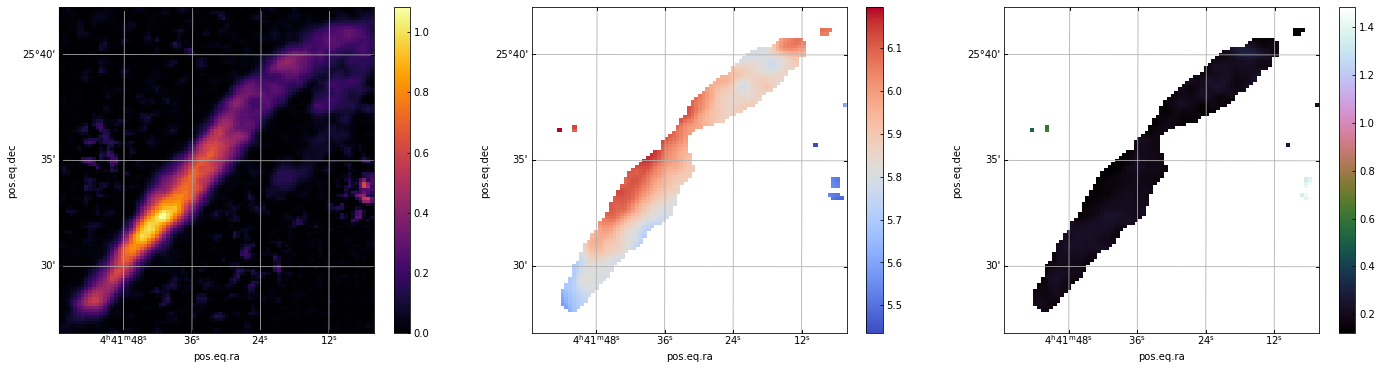

In [95]:
fig = plt.figure(figsize=[24, 6], constrained_layout=False)


ax1 = fig.add_subplot(131, projection=fs_tmc1.wcs)
im1 = ax1.pcolormesh(integral[0], cmap="inferno")
cbar1 = plt.colorbar(im1)


ax2 = fig.add_subplot(132, projection=fs_tmc1.wcs)
im2 = ax2.pcolormesh(fs_g1*position[0], cmap="coolwarm")
#plt.yticks([])
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(133, projection=fs_tmc1.wcs)
im3 = ax3.pcolormesh(fs_g1*dispersion[0], cmap="cubehelix")
#plt.yticks([])
cbar3 = plt.colorbar(im3)

plt.show()

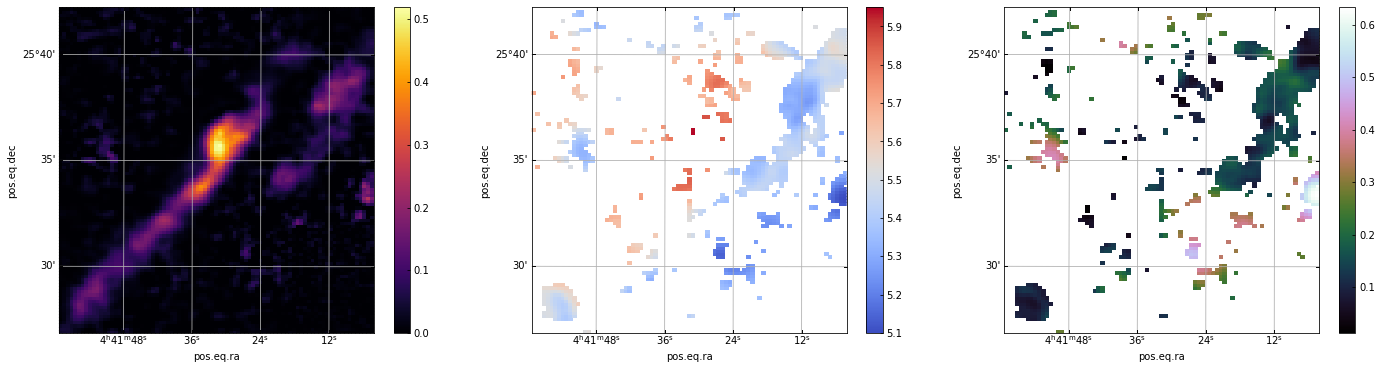

In [86]:
fig = plt.figure(figsize=[24, 6], constrained_layout=False)


ax1 = fig.add_subplot(131, projection=fs_tmc1.wcs)
im1 = ax1.pcolormesh(integral[1], cmap="inferno")
cbar1 = plt.colorbar(im1)


ax2 = fig.add_subplot(132, projection=fs_tmc1.wcs)
im2 = ax2.pcolormesh(fs_g2*position[1], cmap="coolwarm")
#plt.yticks([])
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(133, projection=fs_tmc1.wcs)
im3 = ax3.pcolormesh(fs_g2*dispersion[1], cmap="cubehelix")
#plt.yticks([])
cbar3 = plt.colorbar(im3)

plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

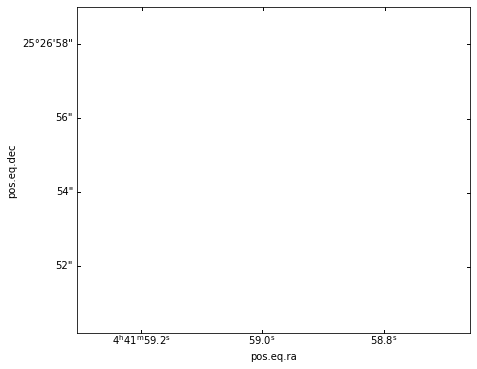

In [87]:
fig = plt.figure(figsize=[24, 6], constrained_layout=False)


ax1 = fig.add_subplot(131, projection=fs_tmc1.wcs)
im1 = ax1.pcolormesh(integral[2], cmap="inferno")
cbar1 = plt.colorbar(im1)


ax2 = fig.add_subplot(132, projection=fs_tmc1.wcs)
im2 = ax2.pcolormesh(fs_g3*position[2], cmap="coolwarm")
#plt.yticks([])
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(133, projection=fs_tmc1.wcs)
im3 = ax3.pcolormesh(fs_g3*dispersion[2], cmap="cubehelix")
#plt.yticks([])
cbar3 = plt.colorbar(im3)

plt.show()

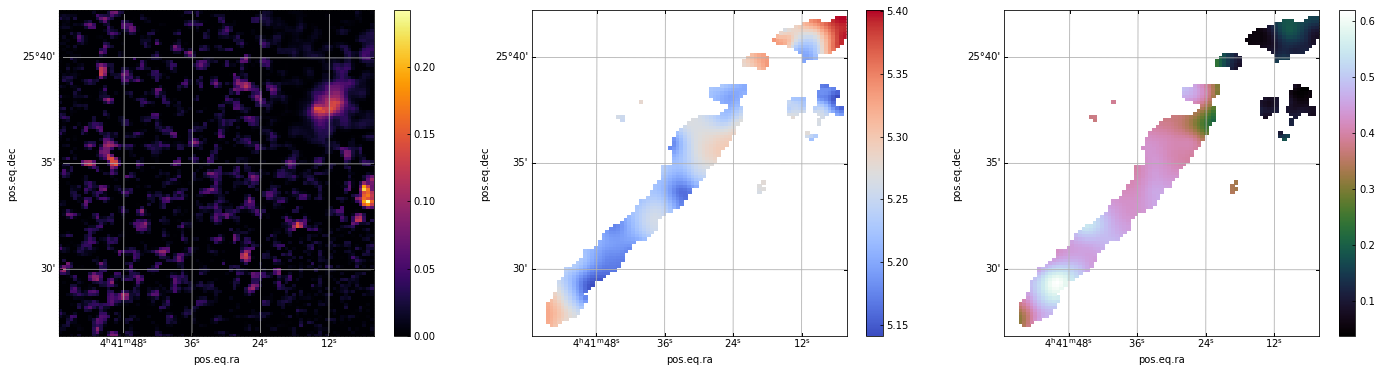

In [81]:
fig = plt.figure(figsize=[24, 6], constrained_layout=False)


ax1 = fig.add_subplot(131, projection=fs_tmc1.wcs)
im1 = ax1.pcolormesh(integral[3], cmap="inferno")
cbar1 = plt.colorbar(im1)


ax2 = fig.add_subplot(132, projection=fs_tmc1.wcs)
im2 = ax2.pcolormesh(fs_g3*position[3], cmap="coolwarm")
#plt.yticks([])
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(133, projection=fs_tmc1.wcs)
im3 = ax3.pcolormesh(fs_g3*dispersion[3], cmap="cubehelix")
#plt.yticks([])
cbar3 = plt.colorbar(im3)

plt.show()

In [206]:
integral[0].shape

(105, 85)

Fit four components, residuals

In [ ]:
fs_tmc1

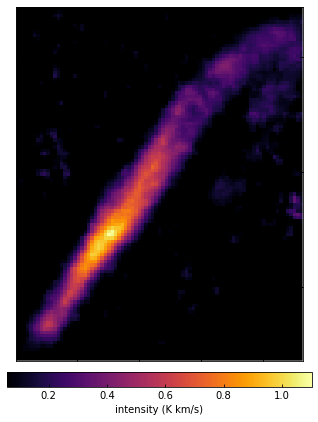

In [103]:
fig = plt.figure(figsize=(6, 7), constrained_layout=False)
ax1 = fig.add_subplot(111, projection=fs_tmc1.wcs)
im = ax1.imshow(fs_gt*(integral[0]+integral[1]+integral[2]+integral[3]+integral[4]), cmap='inferno')
ra = ax1.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
dec = ax1.coords[1]
ax1.set_xlabel('RA (J2000)')
ax1.set_ylabel('DEC (J2000)')
dec.set_ticklabel_visible(False)
ra.set_ticklabel_visible(False)

cbar = plt.colorbar(im, fraction=0.04, pad=0.03,orientation='horizontal')
cbar.set_label('intensity (K km/s)')

In [53]:
def chi2_test(dat, rec):    
    
    chi2s = np.zeros(np.sum(dat, 0).shape)
    for i in range(0, chi2s.shape[1]):
        for j in range(0, chi2s.shape[0]):

            spec = dat.T[i][j]
            fit = rec.T[i][j]
            res = spec - fit
            std = np.std(res)
            deg = len(rad_v) - 3
            chi2 = np.sum((res)**2)/std**2/deg
            chi2s[j][i] = chi2
            
    return chi2s

In [54]:
chi2_test(fs_data, reconstructed_cube)

array([[1.05709357, 1.19243867, 1.13987126, ..., 1.05555435, 1.04210511,
        1.08921345],
       [1.35770065, 1.05192505, 1.19047398, ..., 1.03939035, 1.04284287,
        1.10499263],
       [1.12171788, 1.14260918, 1.04272831, ..., 1.0392081 , 1.04538102,
        1.03932047],
       ...,
       [1.03938126, 1.04895791, 1.05075303, ..., 1.14808422, 1.07216053,
        1.17144806],
       [1.0399755 , 1.05419336, 1.07264246, ..., 1.04379876, 1.10025949,
        1.10727826],
       [1.07879353, 1.04827315, 1.04596608, ..., 1.05626481, 1.12030481,
        1.10067648]])

In [90]:
chi2s = np.zeros(np.sum(fs_data, 0).shape)
for i in range(0, chi2s.shape[1]):
    for j in range(0, chi2s.shape[0]):

        spec = fs_data.T[i][j]
        fit = reconstructed_cube.T[i][j]
        res = spec - fit
        std = np.std(res)
        deg = len(rad_v) - 3
        chi2 = np.sum((res)**2)/std**2/deg
        chi2s[j][i] = chi2
        

In [42]:
chi2s.shape[0]

105

In [43]:
chi2s.shape[1]

85

In [46]:
chi2s.shape

(105, 85)

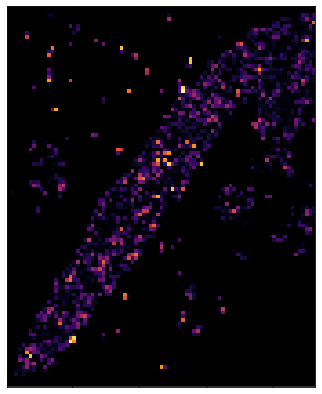

In [96]:
fig = plt.figure(figsize=(6, 7), constrained_layout=False)
ax1 = fig.add_subplot(111, projection=fs_tmc1.wcs)
im = ax1.imshow(fs_gt*chi2s, cmap='inferno')
ra = ax1.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
dec = ax1.coords[1]
ax1.set_xlabel('RA (J2000)')
ax1.set_ylabel('DEC (J2000)')
dec.set_ticklabel_visible(False)
ra.set_ticklabel_visible(False)

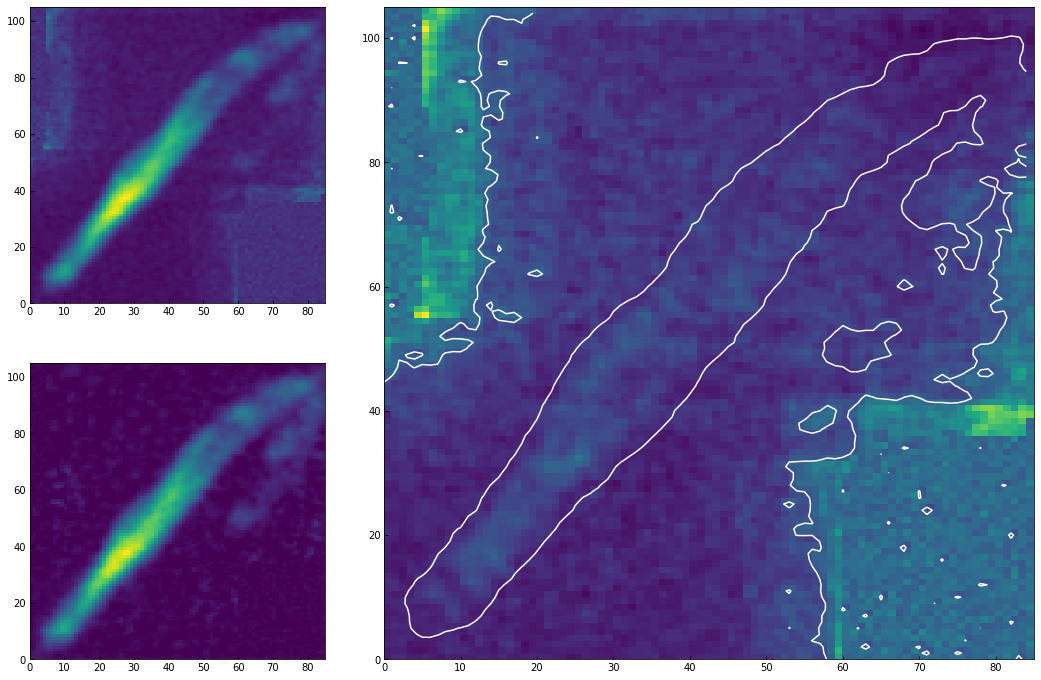

In [97]:
fig = plt.figure(figsize=[18, 12], constrained_layout=False)

gs = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0])

ax1 = fig.add_subplot(gs1[0])
ax1.pcolormesh(np.std(fs_data,0))
#ax1.contour(RA[ra1:ra2], DEC[dec1:dec2], np.std(data,0), colors='white', levels=np.arange(0, 0.25, 0.05))

ax2 = fig.add_subplot(gs1[1])
ax2.pcolormesh(np.std(reconstructed_cube, 0))
#ax2.contour(RA[ra1:ra2], DEC[dec1:dec2], np.std(data,0), colors='white', levels=np.arange(0, 0.25, 0.05))

gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1:])

ax3 = fig.add_subplot(gs2[0])
ax3.pcolormesh(np.std(fs_data - reconstructed_cube, 0))
ax3.contour(np.std(fs_data,0), colors='white', levels=np.arange(0.2, 0.25, 0.05))

plt.show()

In [62]:
w=wcs.WCS(ls_head)

In [63]:
if w:
    print('yo')
else:
    print('nyo')

yo


# TMC-1, lower section

In [13]:
#TMC-1 Lower Section Masks

ls_mask1 = integral[0] > 0.03
ls_g1 = np.empty(ls_mask1.shape)
ls_g1.fill(np.nan)
ls_g1[ls_mask1 == True] = 1

ls_mask2 = integral[1] > 0.08
ls_g2 = np.empty(ls_mask2.shape)
ls_g2.fill(np.nan)
ls_g2[ls_mask2 == True] = 1

ls_mask3 = integral[2] > 0.05 
ls_g3 = np.empty(ls_mask3.shape)
ls_g3.fill(np.nan)
ls_g3[ls_mask3 == True] = 1

total_int = integral[0]+integral[1]+integral[2]
ls_maskt = total_int > 0.16
ls_gt = np.empty(ls_maskt.shape)
ls_gt.fill(np.nan)
ls_gt[ls_maskt == True] = 1

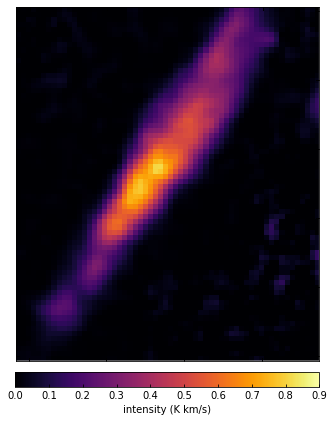

In [14]:
fig = plt.figure(figsize=(6, 7), constrained_layout=False)
ax1 = fig.add_subplot(111, projection=ls_tmc1.wcs)
im = ax1.imshow(integral[1], cmap='inferno', vmin=0, vmax=0.9)
ra = ax1.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
dec = ax1.coords[1]
ax1.set_xlabel('RA (J2000)')
ax1.set_ylabel('DEC (J2000)')
dec.set_ticklabel_visible(False)
ra.set_ticklabel_visible(False)

cbar = plt.colorbar(im, fraction=0.04, pad=0.03,orientation='horizontal')
cbar.set_label('intensity (K km/s)')

#plt.savefig('second_comp_inv.jpg')

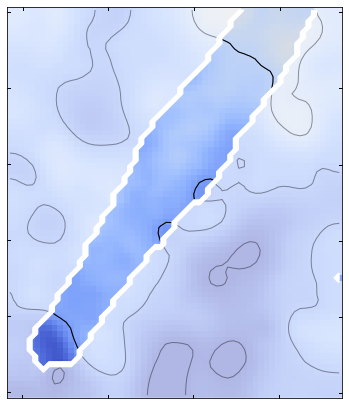

In [17]:
l = np.arange(5.4, 6.1, 0.1)
l2 = np.arange(5.4, 6.4, 0.2)
fig = plt.figure(figsize=(6, 10), constrained_layout=False)
ax1 = fig.add_subplot(111, projection=ls_tmc1.wcs)
ax1.contour(position[2], colors="k", linewidths=1, alpha=0.4, levels=l2)
ax1.imshow(position[2], cmap="coolwarm", alpha=0.4, vmin=5.4, vmax=6.4)
ax1.contour(ls_gt*position[2], colors="k", linewidths=1, levels=l2)
im = ax1.imshow(ls_gt*position[2], cmap="coolwarm", vmin=5.4, vmax=6.4)
#cbar = plt.colorbar(im, pad=0.03,orientation='horizontal')
#cbar.set_label('v relative (km/s)')

ax1.contour(ls_maskt, colors="white", linewidths=2)

ra = ax1.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
dec = ax1.coords[1]
ax1.set_xlabel('RA (J2000)')
ax1.set_ylabel('DEC (J2000)')
dec.set_ticklabel_visible(False)
ra.set_ticklabel_visible(False)

#plt.contour(RA[ra1:ra2], DEC[dec1:dec2], mask1*integral[0], colors="white", levels=l1std)
#plt.title('Visualizing the Velocity Map')
#plt.savefig('velo_map_second.png')

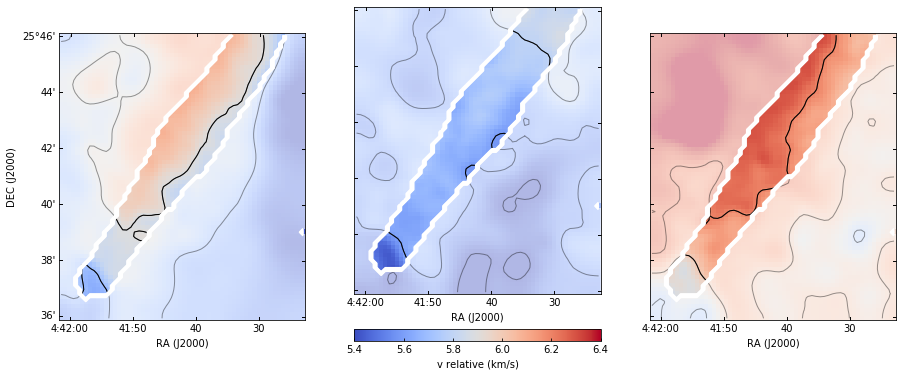

In [16]:
l2 = np.arange(5.4, 6.4, 0.2)
fig = plt.figure(figsize=(15, 8), constrained_layout=False)
ax1 = fig.add_subplot(131, projection=ls_tmc1.wcs)
ax1.contour(position[1], colors="k", linewidths=1, alpha=0.4, levels=np.arange(5.7, 6.1, 0.2))
ax1.imshow(position[1], cmap="coolwarm", alpha=0.4, vmin=5.4, vmax=6.4)
ax1.contour(ls_gt*position[1], colors="k", linewidths=1, levels=np.arange(5.7, 6.1, 0.2))
im1 = ax1.imshow(ls_gt*position[1], cmap="coolwarm", vmin=5.4, vmax=6.4)
#cbar = plt.colorbar(im1, pad=0.06,orientation='horizontal')
#cbar.set_label('v relative (km/s)')

ax1.contour(ls_maskt, colors="white", linewidths=2)

ra = ax1.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
dec = ax1.coords[1]
ax1.set_xlabel('RA (J2000)')
ax1.set_ylabel('DEC (J2000)')


ax2 = fig.add_subplot(132, projection=ls_tmc1.wcs)
ax2.contour(position[2], colors="k", linewidths=1, alpha=0.4, levels=l2)
ax2.imshow(position[2], cmap="coolwarm", alpha=0.4, vmin=5.4, vmax=6.4)
ax2.contour(ls_gt*position[2], colors="k", linewidths=1, levels=l2)
im2 = ax2.imshow(ls_gt*position[2], cmap="coolwarm", vmin=5.4, vmax=6.4)
cbar = plt.colorbar(im2, pad=0.08,orientation='horizontal')
cbar.set_label('v relative (km/s)')

ax2.contour(ls_maskt, colors="white", linewidths=2)

ra = ax2.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
dec = ax2.coords[1]
ax2.set_xlabel('RA (J2000)')
ax2.set_ylabel('DEC (J2000)')
dec.set_ticklabel_visible(False)


ax3 = fig.add_subplot(133, projection=ls_tmc1.wcs)
ax3.contour(position[0], colors="k", linewidths=1, alpha=0.4, levels=l2)
ax3.imshow(position[0], cmap="coolwarm", alpha=0.4, vmin=5.4, vmax=6.4)
ax3.contour(ls_gt*position[0], colors="k", linewidths=1, levels=l2)
im3 = ax3.imshow(ls_gt*position[0], cmap="coolwarm", vmin=5.4, vmax=6.4)
#cbar = plt.colorbar(im3, pad=0.06,orientation='horizontal')
#cbar.set_label('v relative (km/s)')

ax3.contour(ls_maskt, colors="white", linewidths=2)

ra = ax3.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
dec = ax3.coords[1]
ax3.set_xlabel('RA (J2000)')
ax3.set_ylabel('DEC (J2000)')
dec.set_ticklabel_visible(False)

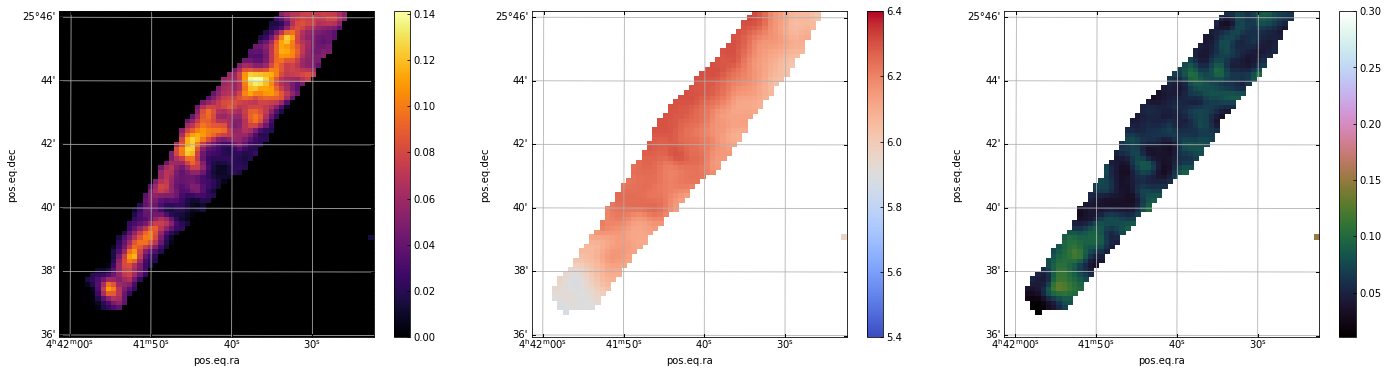

In [18]:
fig = plt.figure(figsize=[24, 6], constrained_layout=False)


ax1 = fig.add_subplot(131, projection=ls_tmc1.wcs)
im1 = ax1.pcolormesh(ls_gt*integral[0], cmap="inferno")
cbar1 = plt.colorbar(im1)


ax2 = fig.add_subplot(132, projection=ls_tmc1.wcs)
im2 = ax2.pcolormesh(ls_gt*position[0], cmap="coolwarm", vmin=5.4, vmax=6.4)
#plt.yticks([])
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(133, projection=ls_tmc1.wcs)
im3 = ax3.pcolormesh(ls_gt*dispersion[0], cmap="cubehelix", vmax=0.3)
#plt.yticks([])
cbar3 = plt.colorbar(im3)

plt.show()

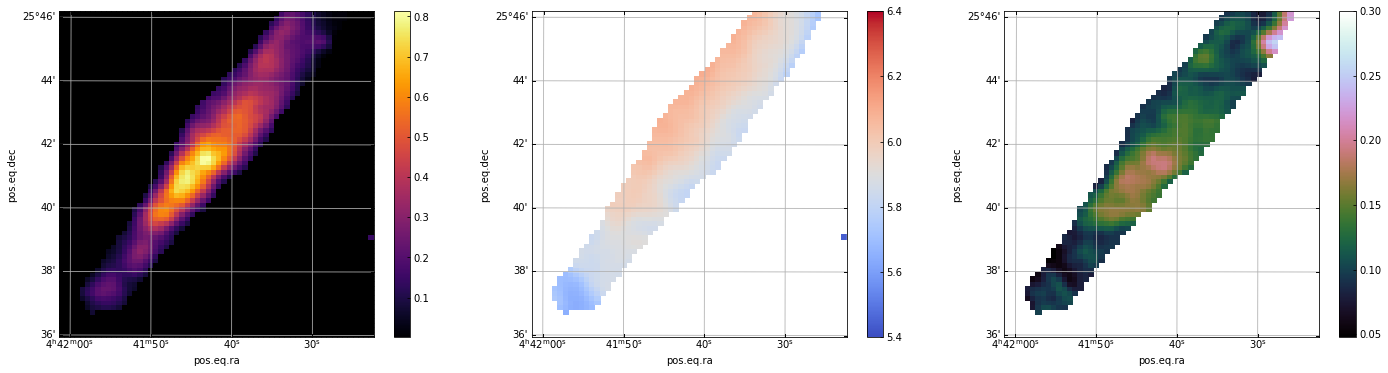

In [19]:
fig = plt.figure(figsize=[24, 6], constrained_layout=False)


ax1 = fig.add_subplot(131, projection=ls_tmc1.wcs)
im1 = ax1.pcolormesh(ls_gt*integral[1], cmap="inferno")
cbar1 = plt.colorbar(im1)


ax2 = fig.add_subplot(132, projection=ls_tmc1.wcs)
im2 = ax2.pcolormesh(ls_gt*position[1], cmap="coolwarm", vmin=5.4, vmax=6.4)
#plt.yticks([])
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(133, projection=ls_tmc1.wcs)
im3 = ax3.pcolormesh(ls_gt*dispersion[1], cmap="cubehelix", vmax=0.3)
#plt.yticks([])
cbar3 = plt.colorbar(im3)

plt.show()

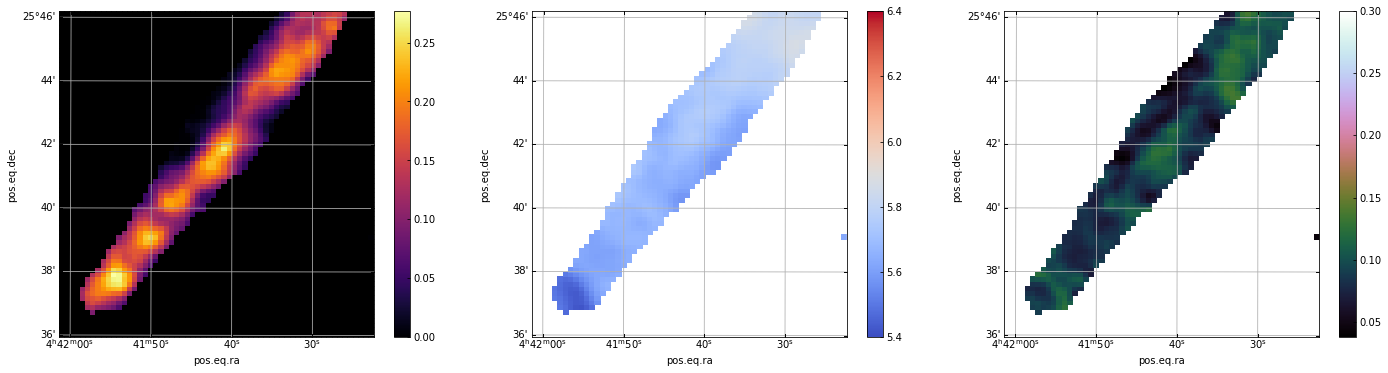

In [20]:
fig = plt.figure(figsize=[24, 6], constrained_layout=False)


ax1 = fig.add_subplot(131, projection=ls_tmc1.wcs)
im1 = ax1.pcolormesh(ls_gt*integral[2], cmap="inferno")
cbar1 = plt.colorbar(im1)


ax2 = fig.add_subplot(132, projection=ls_tmc1.wcs)
im2 = ax2.pcolormesh(ls_gt*position[2], cmap="coolwarm", vmin=5.4, vmax=6.4)
#plt.yticks([])
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(133, projection=ls_tmc1.wcs)
im3 = ax3.pcolormesh(ls_gt*dispersion[2], cmap="cubehelix", vmax=0.3)
#plt.yticks([])
cbar3 = plt.colorbar(im3)

plt.show()

In [949]:
tc_ra[c1ra1:c1ra2][30]

70.42634217013526

### Kinematics

In [84]:
r_mod = reload(r_mod)
cd = reload(cd)

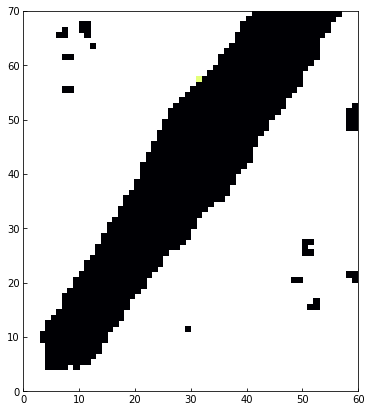

In [929]:
pt = np.zeros(ls_gt.shape)
pt[57][31] = 10

mask = pt > 0
pts = np.empty(mask.shape)
pts.fill(np.nan)
pts[mask == True] = 10

plt.figure(figsize=(6, 7))
plt.pcolormesh(ls_gt, cmap='magma')
plt.pcolormesh(pts, cmap='Wistia')

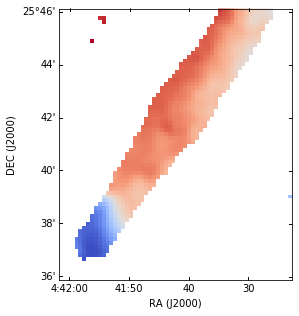

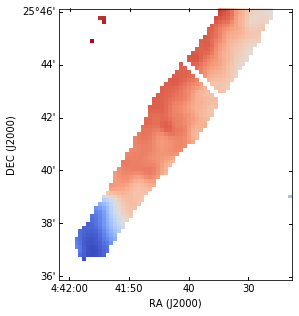

In [427]:
curve = r_mod.line_dec_inst([31, 57], ls_gt*position[0], -1, c='coolwarm', w=ls_tmc1.wcs)

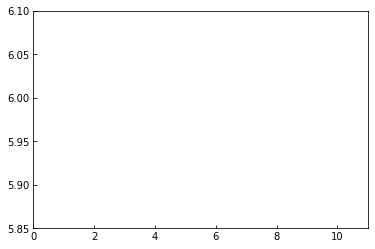

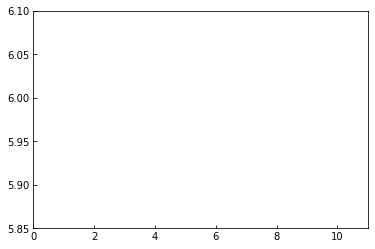

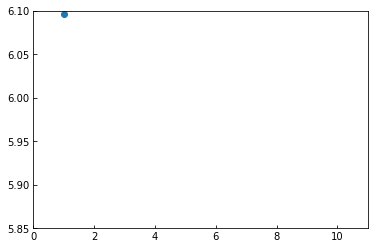

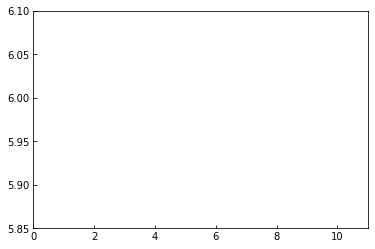

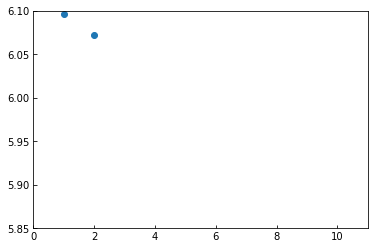

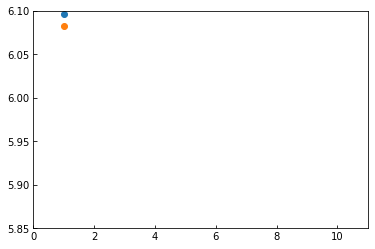

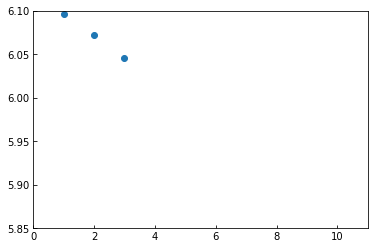

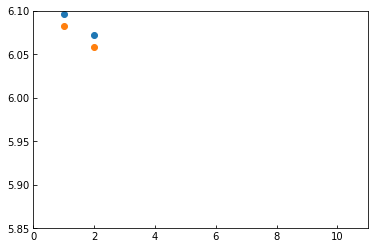

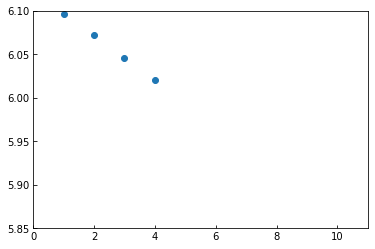

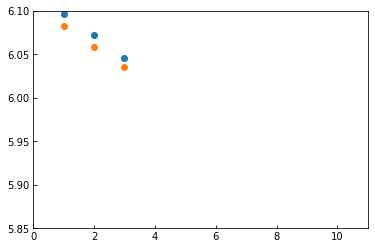

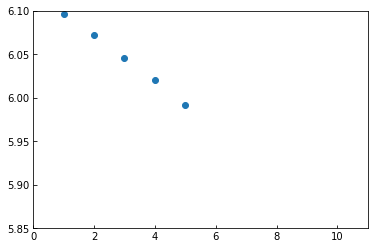

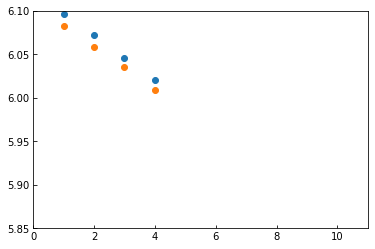

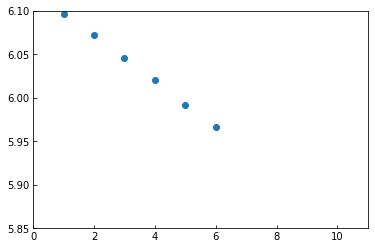

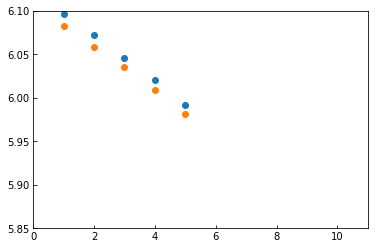

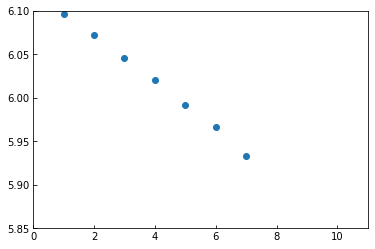

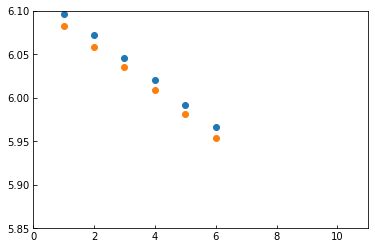

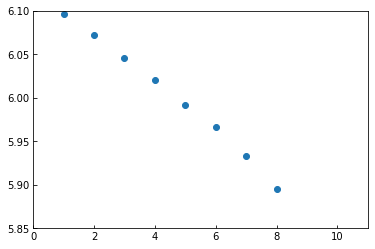

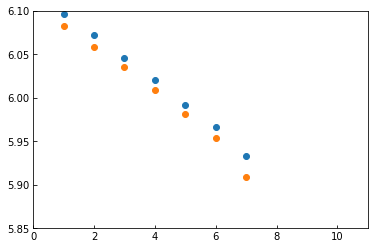

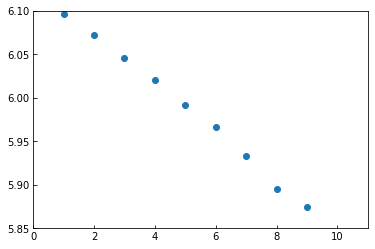

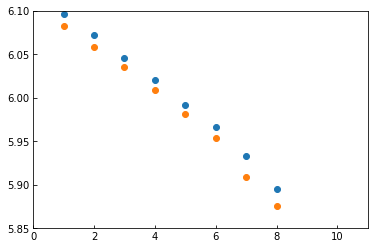

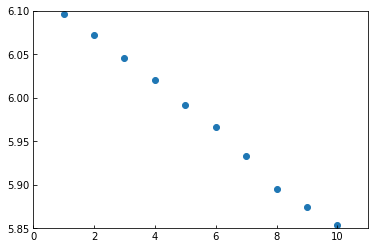

IndexError: list index out of range

In [113]:
up = curve[::2]
low = curve[1::2]

x = np.arange(0, len(up))

plot_up = []
plot_low = []

for i in range(0, len(up)+2):
    plot_up.append(up[i])
    plt.scatter(x[:i+1], plot_up)
    plt.xlim([0, len(up)])
    plt.ylim([5.85, 6.1])
    plt.show()
    
    plot_low.append(low[i])
    plt.scatter(x[:i], up[:i])
    plt.scatter(x[:i], low[:i])
    plt.xlim([0, len(up)])
    plt.ylim([5.85, 6.1])
    plt.show()
    

In [598]:
len(curve), 72.6*pix_scale_pc

(84, <Quantity 0.43356264 pc>)

In [599]:
(0.43)*np.pi*(0.035)**2

0.0016548339302784236

In [74]:
low

[6.0829986332254355,
 6.059305557739058,
 6.035255762379707,
 6.009207312320801,
 5.980852716967478,
 5.953319035255032,
 5.9095198185162445,
 5.8760829748692185,
 5.860831739044119]

In [428]:
up = curve[::2]
low = curve[1::2]
step = np.sqrt(2)

up.pop(0)
low.pop(0)

x_up = np.arange(-4*step, step*6, step)*pix_scale_pc/u.pc

x_low = np.arange(-4*step+step/2, step*5+step/2, step)*pix_scale_pc/u.pc

Text(0.05,0.25,'The two lines have \nbeen separated by \n0.08 km/s to be \ndistinguished')

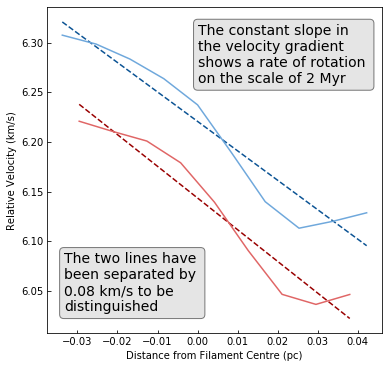

In [429]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111)

p_up, v_up = curve_fit(lin, x_up, up)
p_low, v_low = curve_fit(lin, x_low, low)

fit_up = lin(x_up, p_up[0], p_up[1])
fit_low = lin(x_low, p_low[0], p_low[1])

ax.plot(x_up, fit_up, color='#0b5394', alpha=1, linestyle='--')
ax.plot(x_low, np.array(fit_low)-0.08, color='#990000', alpha=1, linestyle='--')

ax.plot(x_up, up, color='#6fa8dc')
ax.plot(x_low, np.array(low)-0.08, color='#e06666')

ax.set_xlabel('Distance from Filament Centre (pc)')
ax.set_ylabel('Relative Velocity (km/s)')

textstr1 = 'The constant slope in \nthe velocity gradient \nshows a rate of rotation \non the scale of 2 Myr'
textstr2 = 'The two lines have \nbeen separated by \n0.08 km/s to be \ndistinguished'
props = dict(boxstyle='round', facecolor=(0.8,0.8,0.8), alpha=0.5)
ax.text(0.45, 0.95, textstr, transform=ax.transAxes, verticalalignment='top', fontsize='14', bbox=props)
ax.text(0.05, 0.25, textstr2, transform=ax.transAxes, verticalalignment='top', fontsize='14', bbox=props)

#plt.savefig('vel_grad.png')


In [431]:
2*np.pi/(p_up[0]*u.km/u.s/u.pc).to(1/u.Myr)

<Quantity -2.07422741 Myr>

In [87]:
def lin(x, m, b):
    """
    Linear plot
    """
    
    return m*x + b

In [496]:
omega = np.mean([p_up[0], p_low[0]])*u.km/u.s/pix_scale_au

In [498]:
omega.decompose()

<Quantity -1.06653693e-13 1 / s>

In [505]:
KE_rot = 1/4*M_L*(0.085/2*u.pc)**2*omega**2

In [508]:
KE_rot.to(u.J/u.pc)

<Quantity 2.52546083e+24 J / pc>

### Column Densities

In [157]:
hc5n_params = {'nu' : 23.9638968*u.GHz,
                   'jlow' : 8,
                   'jup' : 9,
                   'Elow' : 4.6003*u.K,
                   'Eup' : 5.7505*u.K,
                   'mu' : 4.33e-18*u.esu*u.cm,
                   'Sij' : 0.47, 
                   'b' : 1331.33*u.MHz}


tex = 8.5*u.K
nu = hc5n_params['nu']
tbg = 2.73*u.K

In [33]:
tex = 7.3*u.K

n_ls_g1_73, tau_ls_g1_73 = cd.calc_n_mangum(tmb_ls_g1,tex,dv_ls_g1,hc5n_params,0)
n_ls_g2_73, tau_ls_g2_73 = cd.calc_n_mangum(tmb_ls_g2,tex,dv_ls_g2,hc5n_params,0)
n_ls_g3_73, tau_ls_g3_73 = cd.calc_n_mangum(tmb_ls_g3,tex,dv_ls_g3,hc5n_params,0)

n_ls_g1_73 = n_ls_g1_73.decompose()
n_ls_g2_73 = n_ls_g2_73.decompose()
n_ls_g3_73 = n_ls_g3_73.decompose()




In [34]:
tex = 9.6*u.K

n_ls_g1_96, tau_ls_g1_96 = cd.calc_n_mangum(tmb_ls_g1,tex,dv_ls_g1,hc5n_params,0)
n_ls_g2_96, tau_ls_g2_96 = cd.calc_n_mangum(tmb_ls_g2,tex,dv_ls_g2,hc5n_params,0)
n_ls_g3_96, tau_ls_g3_96 = cd.calc_n_mangum(tmb_ls_g3,tex,dv_ls_g3,hc5n_params,0)

n_ls_g1_96 = n_ls_g1_96.decompose()
n_ls_g2_96 = n_ls_g2_96.decompose()
n_ls_g3_96 = n_ls_g3_96.decompose()






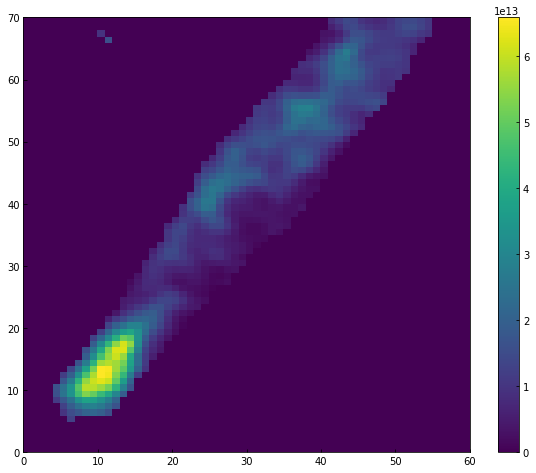

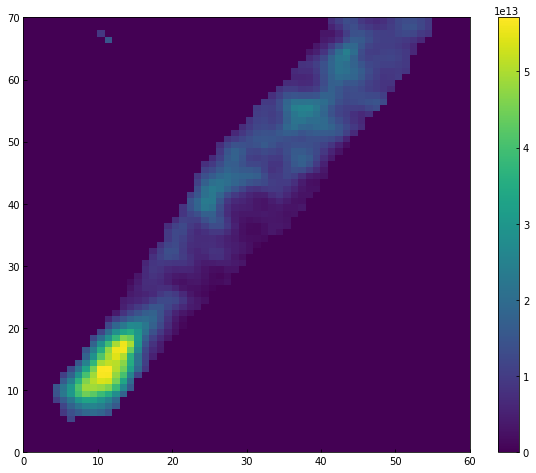

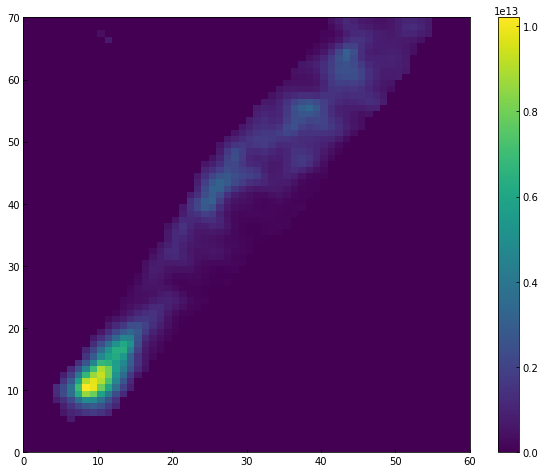

In [35]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g1_73)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g1_96)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g1_73 - ls_maskt*n_ls_g1_96)
plt.colorbar()
plt.show()

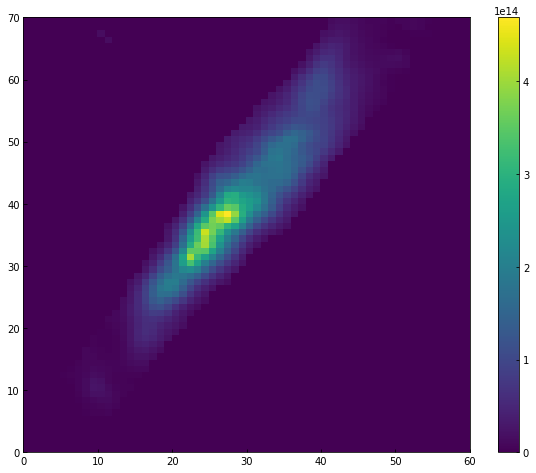

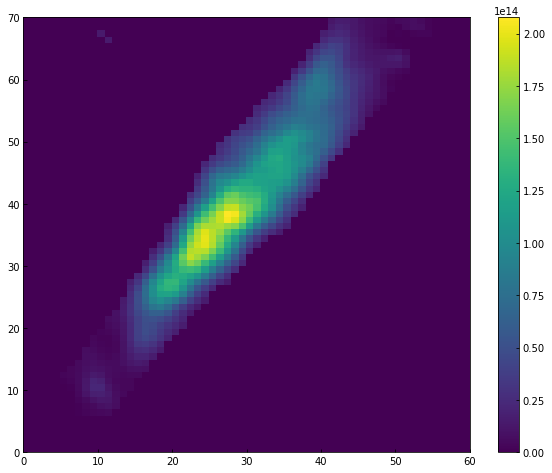

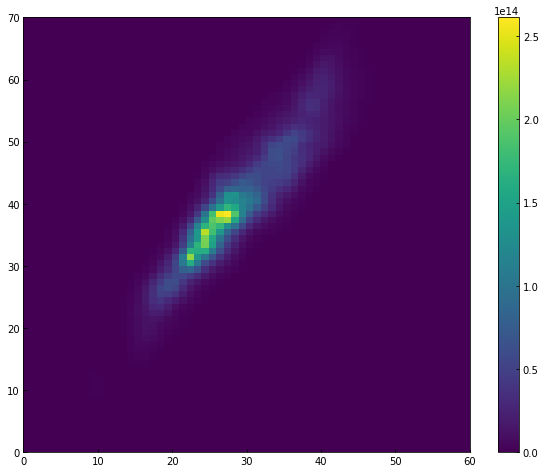

In [37]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g2_73)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g2_96)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 8))
plt.pcolormesh((ls_maskt*n_ls_g2_73 - ls_maskt*n_ls_g2_96))
plt.colorbar()
plt.show()

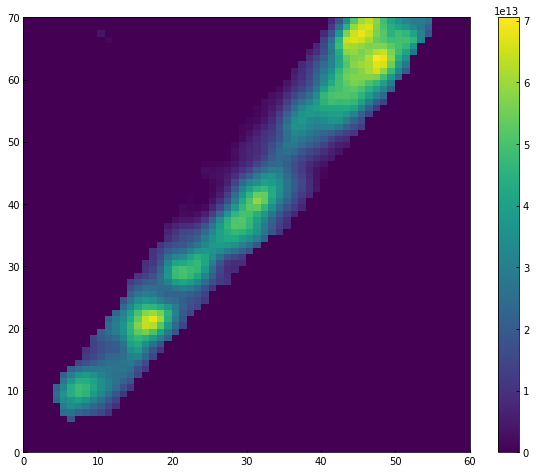

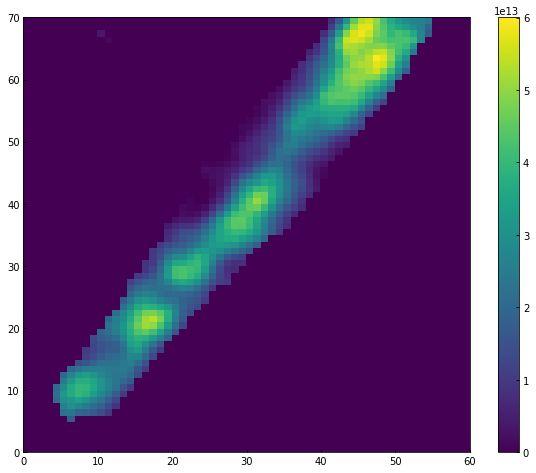

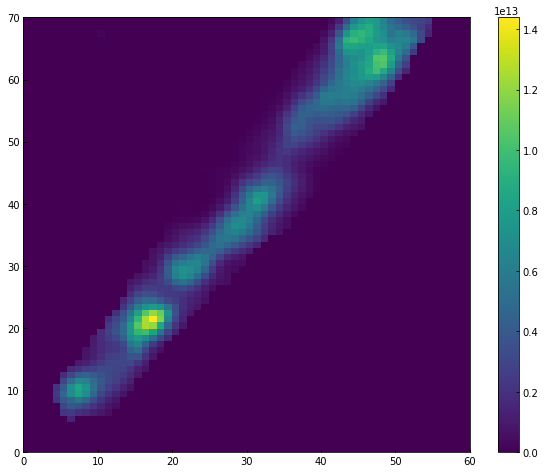

In [38]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g3_73)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g3_96)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g3_73 - ls_maskt*n_ls_g3_96)
plt.colorbar()
plt.show()

In [158]:
tmb_ls_g1, dv_ls_g1 = amplitude[0]*u.K, dispersion[0]*u.m/u.s
tmb_ls_g2, dv_ls_g2 = amplitude[1]*u.K, dispersion[1]*u.m/u.s
tmb_ls_g3, dv_ls_g3 = amplitude[2]*u.K, dispersion[2]*u.m/u.s

In [159]:
n_ls_g1, tau_ls_g1 = cd.calc_n_mangum(tmb_ls_g1,tex,dv_ls_g1,hc5n_params,0)
n_ls_g2, tau_ls_g2 = cd.calc_n_mangum(tmb_ls_g2,tex,dv_ls_g2,hc5n_params,0)
n_ls_g3, tau_ls_g3 = cd.calc_n_mangum(tmb_ls_g3,tex,dv_ls_g3,hc5n_params,0)
n_ls_g1 = n_ls_g1.decompose()
n_ls_g2 = n_ls_g2.decompose()
n_ls_g3 = n_ls_g3.decompose()

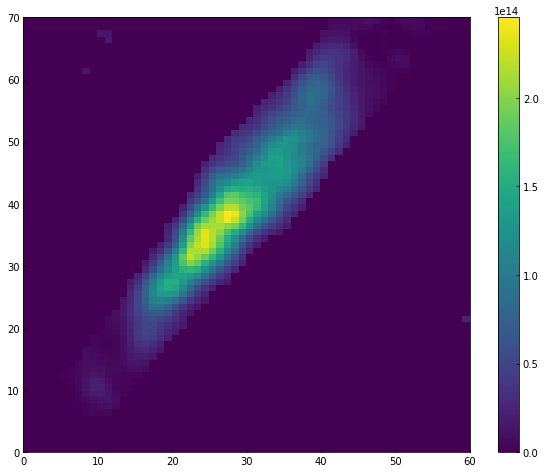

In [160]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g2)
plt.colorbar()
plt.show()

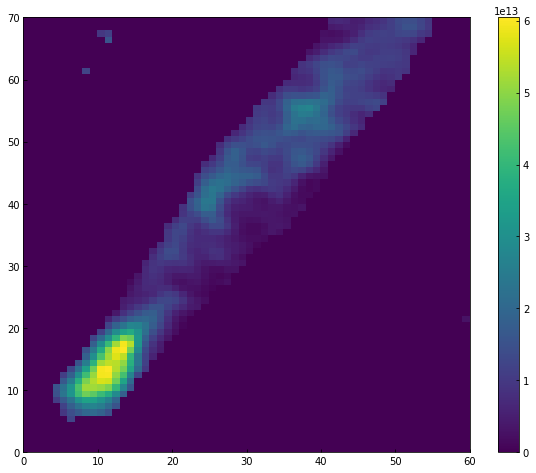

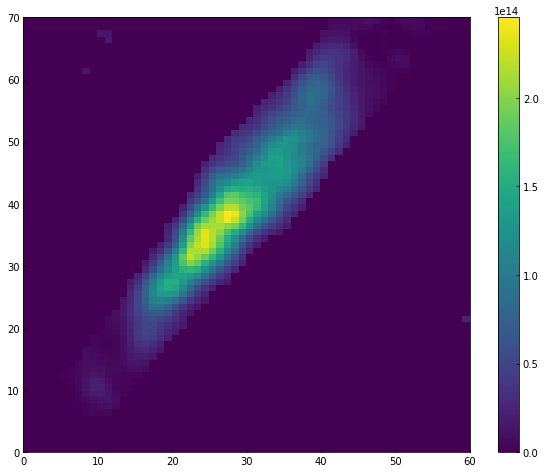

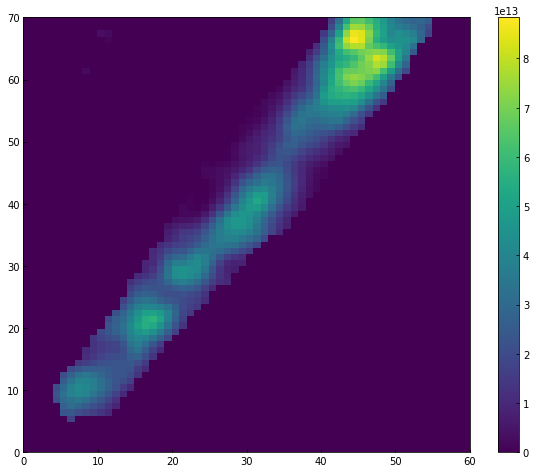

In [206]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g1)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g2)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 8))
plt.pcolormesh(ls_maskt*n_ls_g3)
plt.colorbar()
plt.show()

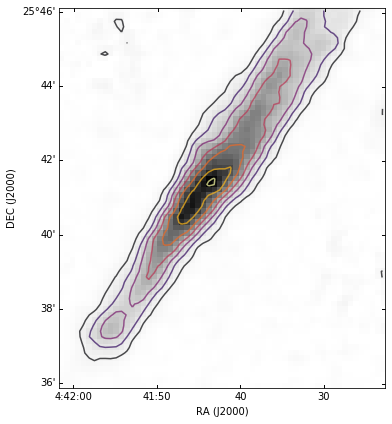

In [226]:
fig = plt.figure(figsize=(6, 7), constrained_layout=False)
ax1 = fig.add_subplot(111, projection=ls_tmc1.wcs)
im = ax1.imshow(n_ls_tot*u.m**2, cmap='Greys')
ax1.contour(total_int, cmap='inferno', alpha=0.7)
ra = ax1.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
dec = ax1.coords[1]
ax1.set_xlabel('RA (J2000)')
ax1.set_ylabel('DEC (J2000)')
#dec.set_ticklabel_visible(False)
#ra.set_ticklabel_visible(False)

#cbar = plt.colorbar(im, fraction=0.04, pad=0.03,orientation='horizontal')
#cbar.set_label('intensity (K km/s)')

#plt.savefig('tot_density.png')

In [162]:
total_gas_g1 = np.ravel(ls_gt*n_ls_g1)
total_gas_g1 = total_gas_g1[~np.isnan(total_gas_g1)]
hc5n_N_g1 = np.sum((total_gas_g1*pix_scale_au**2).decompose())

total_gas_g2 = np.ravel(ls_gt*n_ls_g2)
total_gas_g2 = total_gas_g2[~np.isnan(total_gas_g2)]
hc5n_N_g2 = np.sum((total_gas_g2*pix_scale_au**2).decompose())

total_gas_g3 = np.ravel(ls_gt*n_ls_g3)
total_gas_g3 = total_gas_g3[~np.isnan(total_gas_g3)]
hc5n_N_g3 = np.sum((total_gas_g3*pix_scale_au**2).decompose())

In [163]:
hc5n_N_g1, hc5n_N_g2, hc5n_N_g3 #particles

(<Quantity 4.08899241e+44>,
 <Quantity 1.84846482e+45>,
 <Quantity 8.10871006e+44>)

In [46]:
rat_23, rat_21, rat_31 = hc5n_N_g2/hc5n_N_g3, hc5n_N_g2/hc5n_N_g1, hc5n_N_g3/hc5n_N_g1

In [48]:
tot = hc5n_N_g3 + hc5n_N_g2 + hc5n_N_g1
hc5n_N_g3/tot, hc5n_N_g2/tot, hc5n_N_g1/tot

(<Quantity 0.2455411>, <Quantity 0.61795409>, <Quantity 0.13650481>)

In [164]:
tot_hc5n = (hc5n_N_g1/c.N_A*75.07*u.g/u.mol).to(u.kg) + (hc5n_N_g2/c.N_A*75.07*u.g/u.mol).to(u.kg) + (hc5n_N_g3/c.N_A*75.07*u.g/u.mol).to(u.kg)

In [335]:
(hc5n_N_g1/c.N_A*75.07*u.g/u.mol).to(u.kg)/tot_hc5n


<Quantity 0.11255782>

In [71]:
1/(max(total_gas_g2)/(0.0085*u.pc)).to(1/u.m**3)

<Quantity 0.92545627 m3>

In [381]:
(hc5n_N_g1/c.N_A*75.07*u.g/u.mol).to(u.kg)/tot_hc5n, (hc5n_N_g2/c.N_A*75.07*u.g/u.mol).to(u.kg)/tot_hc5n, (hc5n_N_g3/c.N_A*75.07*u.g/u.mol).to(u.kg)/tot_hc5n

(<Quantity 0.11038493>, <Quantity 0.65959118>, <Quantity 0.23002389>)

In [167]:
tot_hc5n.to(u.M_sun)/(7.63*u.M_sun)

<Quantity 2.52100492e-11>

In [216]:
n_ls_tot = n_ls_g1+n_ls_g2+n_ls_g3

In [179]:
1/(np.nanmax(n_ls_tot)/(2*0.046*u.pc)).decompose()

<Quantity 9.76379249 m3>

## Three things to talk about:
### Three parts of the filament, filaments have multiple components
### Density Profiles
### Temp stuff can be part of density
### stability of filaments can related back to density structures
### Fitting via Rohsa
### Velocity fields indicate... what exactly (how does this relate to stability and flow of material)








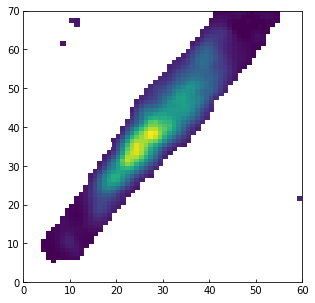

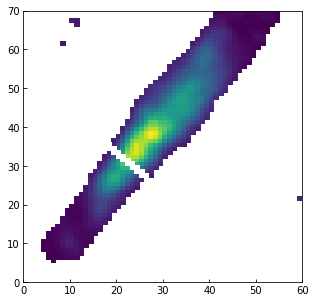

In [292]:
x, y = 18, 35
curve = r_mod.line_dec_inst([x, y], ls_gt*n_ls_g2, -1)

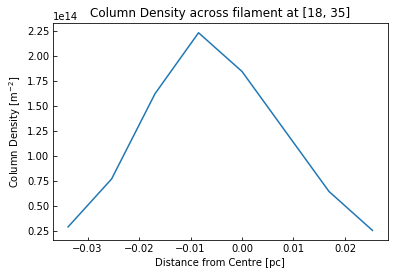

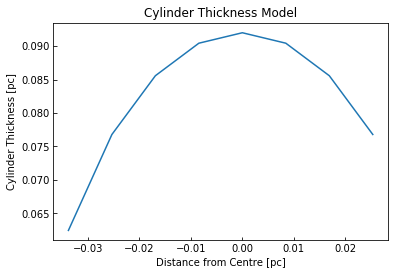

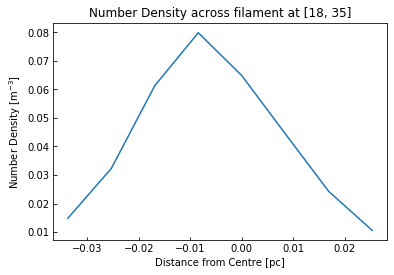

In [300]:
offset = 0

pops = []
for i in range(len(curve)):
    if np.isnan(curve[i]):
        pops.append(i)
for i in pops[::-1]:
    curve.pop(i)

        

colden_test = curve[offset::2]
length = len(colden_test)
mid = np.round(length/2)
a, b = length - mid, 0 - mid

steps = np.arange(b*np.sqrt(2)+offset*np.sqrt(2)/2, a*np.sqrt(2)+offset*np.sqrt(2)/2, np.sqrt(2))*pix_scale_pc
r = 0.046*u.pc
thickness = 2*np.sqrt(r**2 - steps**2)


plt.plot(steps, colden_test)

plt.xlabel('Distance from Centre [pc]')
plt.ylabel('Column Density [m$^{-2}$]')
plt.title('Column Density across filament at ['+str(x)+', '+str(y)+']')

plt.show()

plt.plot(steps, thickness)
plt.xlabel('Distance from Centre [pc]')
plt.ylabel('Cylinder Thickness [pc]')
plt.title('Cylinder Thickness Model')

plt.show()

num_den = (colden_test/u.m**2/thickness).to(1/u.m**3)

plt.plot(steps, num_den)
plt.xlabel('Distance from Centre [pc]')
plt.ylabel('Number Density [m$^{-3}$]')
plt.title('Number Density across filament at ['+str(x)+', '+str(y)+']')

plt.show()

In [294]:
den_1835_0 = num_den

In [374]:
evens=[den_2037_0, den_2141_0, den_2243_0, den_2549_0, den_2752_0, den_2853_0, den_3156_0, den_3358_0]
odds=[den_2037_1, den_2141_1, den_2243_1, den_2549_1, den_2752_1, den_2853_1, den_3156_1, den_3358_1]


11
11
11
11
11
11
11
11


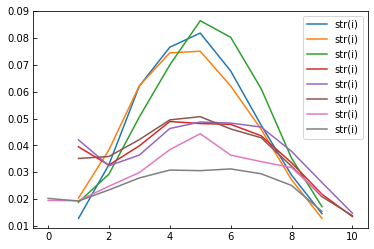

In [375]:
for i in range(len(evens)):
    plt.plot(evens[i], label='str(i)')
    print(len(evens[i]))
plt.legend()

In [373]:

den_3358_0 = [0.020315459, 0.019327409, 0.023464547, 0.027919395, 0.030855943, 0.030641133, 0.031274368, 0.029475458, 0.02513778, 0.01545629, np.nan]/u.m**3





In [329]:
odds_norm = np.array([np.array(den_2037_1/np.nanmax(den_2037_1)), np.array(den_2141_1/np.nanmax(den_2141_1)), 
                      np.array(den_2243_1/np.nanmax(den_2243_1)), np.array(den_2549_1/np.nanmax(den_2549_1)), 
                      np.array(den_2752_1/np.nanmax(den_2752_1)), np.array(den_2853_1/np.nanmax(den_2853_1)), 
                      np.array(den_3156_1/np.nanmax(den_3156_1)), np.array(den_3358_1/np.nanmax(den_3358_1))])



In [376]:
evens_norm = np.array([np.array(den_2037_0/np.nanmax(den_2037_0)), np.array(den_2141_0/np.nanmax(den_2141_0)),
                       np.array(den_2243_0/np.nanmax(den_2243_0)), np.array(den_2549_0/np.nanmax(den_2549_0)), 
                       np.array(den_2752_0/np.nanmax(den_2752_0)), np.array(den_2853_0/np.nanmax(den_2853_0)), 
                       np.array(den_3156_0/np.nanmax(den_3156_0)), np.array(den_3358_0/np.nanmax(den_3358_0))])




In [1038]:
new_evens = []
for e in evens_norm[:-3]:
    a, b = e[6:], e[6::-1]
    new_evens.append(a)
    new_evens.append(b)

In [1056]:
new_odds = []
for e in odds_norm[:-3]:
    a, b = e[6:], e[6::-1]
    new_odds.append(a)
    new_odds.append(b)

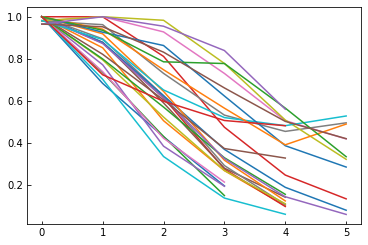

In [1059]:
for i in new_evens:
    plt.plot(i)
    
plt.show()
total_e = []
total_std_e = []
for index in range(len(new_evens[0])):
    temp = []
    for profile in new_evens:
        temp.append(profile[index])
        
    
    total_e.append(np.nanmean(temp))
    total_std_e.append(np.nanstd(temp))

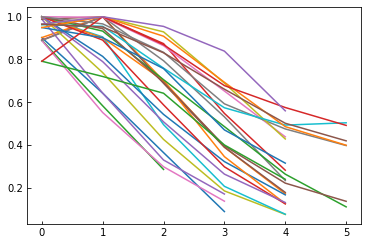

In [1057]:
for i in new_odds:
    plt.plot(i)
    
plt.show()
total_o = []
total_std_o = []
for index in range(len(new_odds[0])):
    temp = []
    for profile in new_odds:
        temp.append(profile[index])
        
    
    total_o.append(np.nanmean(temp))
    total_std_o.append(np.nanstd(temp))

In [ ]:
plt.figure(figsize=(7, 7))
#plt.errorbar(x=np.arange(0, len(total_e)*np.sqrt(2), np.sqrt(2))*pix_scale_pc/u.pc, y=total_e, yerr=total_std_e)

#plt.errorbar(x=np.arange(0, len(total_o)*np.sqrt(2), np.sqrt(2))*pix_scale_pc/u.pc, y=total_o, yerr=total_std_o)

#plt.errorbar(x=np.arange(0, len(total_o)*np.sqrt(2), np.sqrt(2))*pix_scale_pc/r, 
             #y=np.mean([total_e, total_o], 0), yerr=np.mean([total_std_e, total_std_o], 0))
    
plt.plot(np.arange(0, len(total_o)*np.sqrt(2), np.sqrt(2))*pix_scale_pc/r, np.mean([total_e, total_o], 0))
plt.fill_between(np.arange(0, len(total_o)*np.sqrt(2), np.sqrt(2))*pix_scale_pc/r, 
                 np.mean([total_e, total_o], 0)+np.mean([total_std_e, total_std_o], 0), 
                 np.mean([total_e, total_o], 0)-np.mean([total_std_e, total_std_o], 0), 
                alpha = 0.3)
plt.xlim([0, 1])
plt.ylim([0.1, 1.1])
plt.xlabel('')
plt.ylabel('')
plt.show()

In [1061]:
total = []
total_std = []
for i in range(len(total_e)):
    total.append(total_e[i])
    total.append(total_o[i])
    total_std.append(total_std_e[i])
    total_std.append(total_std_o[i])

<ErrorbarContainer object of 3 artists>

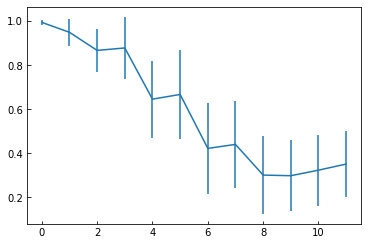

In [1062]:
plt.errorbar(x=np.arange(len(total)), y=total, yerr=total_std)

In [1036]:
a, b = dist[6:], dist[6::-1]

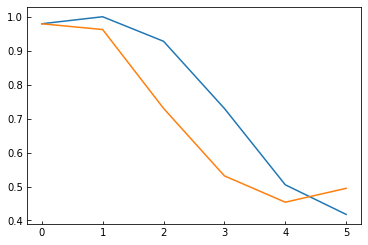

In [1037]:
plt.plot(a)
plt.plot(b)

In [870]:
len(mean_evens), len(std_evens), len(np.arange(-6*np.sqrt(2), 5*np.sqrt(2), np.sqrt(2)))

(12, 12, 11)

In [378]:
mean_evens = np.nanmean(evens_norm, axis=0)
mean_odds = np.nanmean(odds_norm, axis=0)

std_evens = np.nanstd(evens_norm, axis=0)
std_odds = np.nanstd(odds_norm, axis=0)

#plt.errorbar(x=np.arange(-6*np.sqrt(2), 6*np.sqrt(2), np.sqrt(2)), y=mean_evens, yerr=std_evens)
#plt.errorbar(x=np.arange(-6*np.sqrt(2), 6*np.sqrt(2), np.sqrt(2)), y=mean_odds, yerr=std_odds)

In [380]:
normed = []
normed_std = []
for i in range(len(mean_evens)-1):
    normed.append(mean_evens[i])
    normed.append(mean_odds[i])
    normed_std.append(std_evens[i])
    normed_std.append(std_odds[i])
normed.append(mean_evens[-1])
normed_std.append(std_evens[-1])

<ErrorbarContainer object of 3 artists>

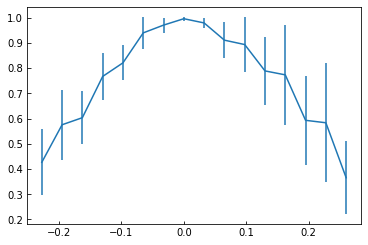

In [393]:
x = np.arange(-7, 9)*np.sqrt(2)/2*r/u.pc
plt.errorbar(x=x, y=normed[3:-2], yerr=normed_std[3:-2])

In [396]:
par, cov = curve_fit(r_mod.quad, x, normed[3:-2], sigma=normed_std[3:-2])


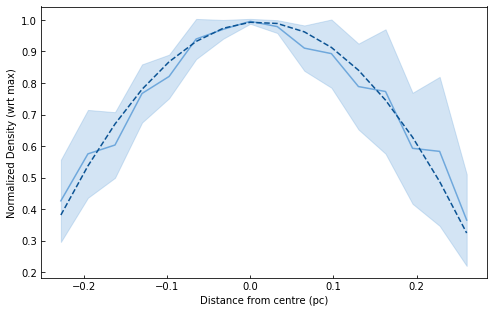

In [418]:
plt.figure(figsize=(8, 5))
plt.plot(x, normed[3:-2], color='#6fa8dc', alpha=1)
plt.plot(x, r_mod.quad(x, par[0], par[1], par[2]), color='#0b5394', alpha=1, linestyle='--')
plt.fill_between(x, np.array(normed[3:-2])+np.array(normed_std[3:-2]), 
                 np.array(normed[3:-2])-np.array(normed_std[3:-2]), color='#6fa8dc', alpha=0.3)
plt.ylabel('Normalized Density (wrt max)')
plt.xlabel('Distance from centre (pc)')
plt.savefig('den_prof.png')

In [ ]:
((np.nanmax(np.ravel(ls_g2*n)))/(0.085*u.pc)).decompose()

In [446]:
h = np.ravel(ls_mask1*n*pix_scale_au**2)
h = h[h != 0]
total_h = np.sum(h)
#ls_den3 = ((total_h*len(h)*pix_scale_au**2).decompose())

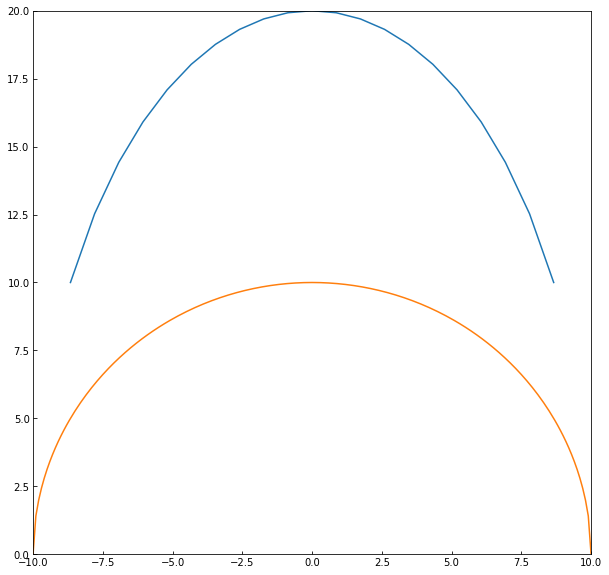

In [543]:
r = 10
lim = np.sqrt(3)/2*r
step = np.sqrt(3)/2

x = np.arange(-lim, lim+step/2, step)
x2 = np.arange(-10, 10.1, 0.1)

plt.figure(figsize=(10, 10))
plt.plot(x, 2*np.sqrt(r**2 - x**2))
plt.plot(x2, np.sqrt(r**2 - x2**2))

plt.xlim([-10, 10])
plt.ylim([0, 20])
plt.show()

In [499]:
M_L = total_h.decompose()*1.25e-25*u.kg/0.43/u.pc

In [450]:
(75.07*u.g/u.mol/c.N_A).to(u.kg)

<Quantity 1.24656668e-25 kg>

In [500]:
M_L

<Quantity 5.16380559e+20 kg / pc>

In [528]:
x

array([-8.66025404e+00, -7.79422863e+00, -6.92820323e+00, -6.06217783e+00,
       -5.19615242e+00, -4.33012702e+00, -3.46410162e+00, -2.59807621e+00,
       -1.73205081e+00, -8.66025404e-01, -1.77635684e-15,  8.66025404e-01,
        1.73205081e+00,  2.59807621e+00,  3.46410162e+00,  4.33012702e+00,
        5.19615242e+00,  6.06217783e+00,  6.92820323e+00,  7.79422863e+00,
        8.66025404e+00])

In [173]:
ls_den1, ls_den2, ls_den3

(<Quantity 2.84790082e+47>,
 <Quantity 2.34324554e+48>,
 <Quantity 5.43877331e+47>)

# TMC-1, upper section

In [172]:
#TMC-1 Upper Section Masks

us_mask1 = integral[0] > 0.1
us_g1 = np.empty(us_mask1.shape)
us_g1.fill(np.nan)
us_g1[us_mask1 == True] = 1

us_mask2 = integral[1] > 0.05
us_g2 = np.empty(us_mask2.shape)
us_g2.fill(np.nan)
us_g2[us_mask2 == True] = 1

us_mask3 = integral[2] > 0.07
us_g3 = np.empty(us_mask3.shape)
us_g3.fill(np.nan)
us_g3[us_mask3 == True] = 1

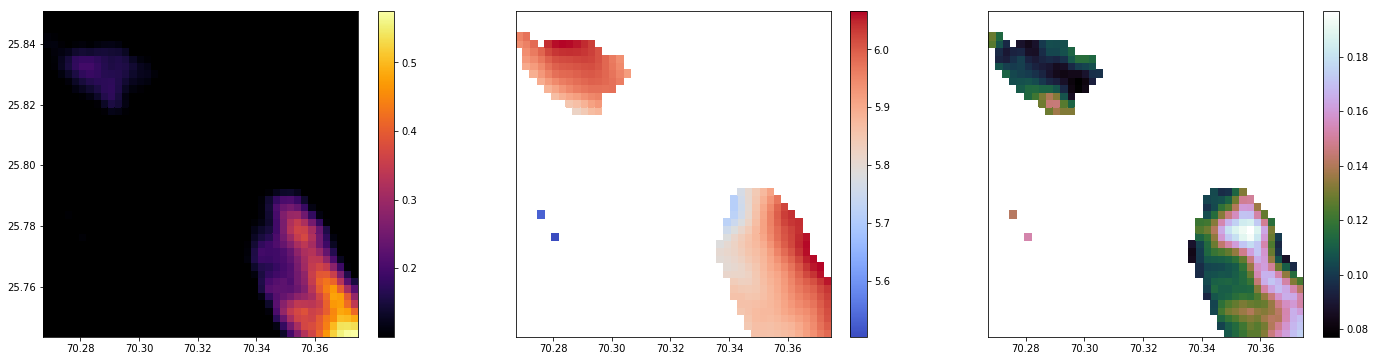

In [161]:
plt.figure(figsize=[24, 6], constrained_layout=False)


plt.subplot(1, 3, 1)
plt.pcolormesh(tc_ra[c2ra1:c2ra2], tc_dec[c2dec1:c2dec2], us_g1*integral[0], cmap="inferno")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.pcolormesh(tc_ra[c2ra1:c2ra2], tc_dec[c2dec1:c2dec2], us_g1*position[0], cmap="coolwarm")
plt.yticks([])
plt.colorbar()

plt.subplot(1, 3, 3)
plt.pcolormesh(tc_ra[c2ra1:c2ra2], tc_dec[c2dec1:c2dec2], us_g1*dispersion[0], cmap="cubehelix")
plt.yticks([])
plt.colorbar()

plt.show()

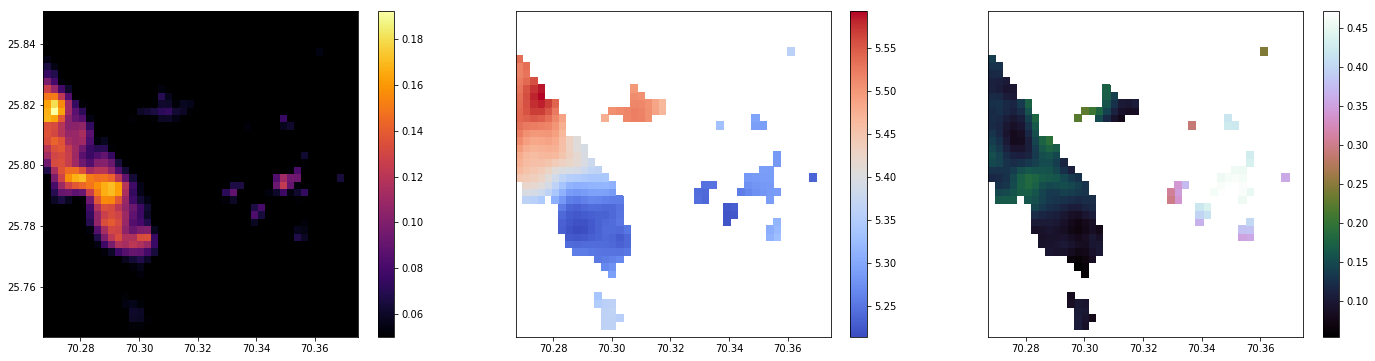

In [169]:
plt.figure(figsize=[24, 6])


plt.subplot(1, 3, 1)
plt.pcolormesh(tc_ra[c2ra1:c2ra2], tc_dec[c2dec1:c2dec2], us_g2*integral[1], cmap="inferno")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.pcolormesh(tc_ra[c2ra1:c2ra2], tc_dec[c2dec1:c2dec2], us_g2*position[1], cmap="coolwarm")
plt.yticks([])
plt.colorbar()

plt.subplot(1, 3, 3)
plt.pcolormesh(tc_ra[c2ra1:c2ra2], tc_dec[c2dec1:c2dec2], us_g2*dispersion[1], cmap="cubehelix")
plt.yticks([])
plt.colorbar()

plt.show()

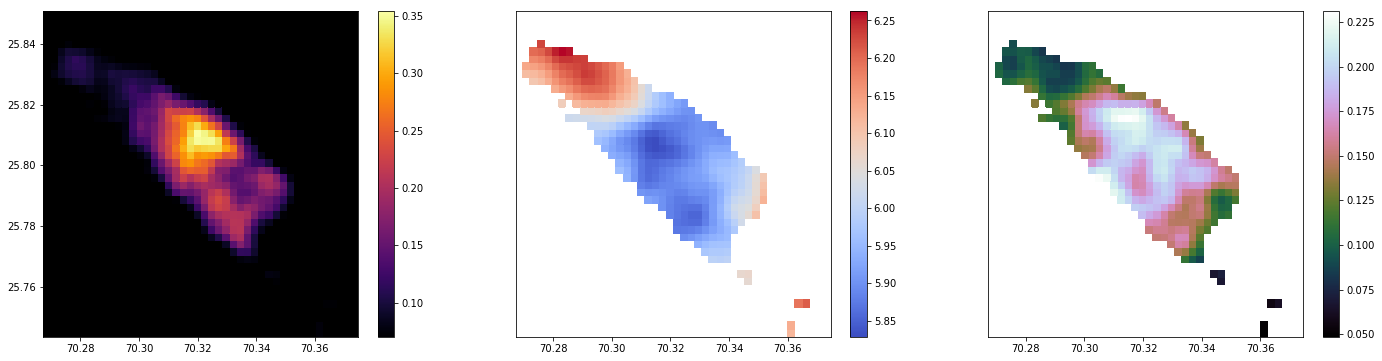

In [174]:
plt.figure(figsize=[24, 6])


plt.subplot(1, 3, 1)
plt.pcolormesh(tc_ra[c2ra1:c2ra2], tc_dec[c2dec1:c2dec2], us_g3*integral[2], cmap="inferno")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.pcolormesh(tc_ra[c2ra1:c2ra2], tc_dec[c2dec1:c2dec2], us_g3*position[2], cmap="coolwarm")
plt.yticks([])
plt.colorbar()

plt.subplot(1, 3, 3)
plt.pcolormesh(tc_ra[c2ra1:c2ra2], tc_dec[c2dec1:c2dec2], us_g3*dispersion[2], cmap="cubehelix")
plt.yticks([])
plt.colorbar()

plt.show()